# Исследование информации о продаже билетов авиакомпании

## Описание данных

## <a class="anchor" id="15th"></a> Навигация:
* [1. Знакомство с данными](#1st) 
* [2. Предобработка данных](#2nd)
*    * [2.1 Приведение заголовков к удобному виду](#3rd)
*    * [2.2 Проверка типов данных](#4th)
*    * [2.3 Обработка пропусков](#5th)
*    * [2.4 Проверка на наличие дубликатов](#6th)
*    * [2.5 Исключение нулевых значений в выручке для дальнейшего исследования](#7th)
* [3. Исследовательский анализ данных](#8th)
*    * [3.1 Создание отчета о динамике продаж (выручке). Построение линейного графика. Повтор отчета с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Построение общих отчетов по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализация каждого отчета. Принятие решения о детализации отчетов.](#9th)
*    * [3.2 Исследование выручки, принятие решения об исключении выбросов для дальнейшего исследования, руководствуясь минимизацией потерь в данных.](#10th)
*    * [3.3 Исследование сезонности продаж. Дополнительная проверка гипотезы о том, что выручка от продаж осенью и зимой отличается. Исследование выручки и числа продаж по месяцам, проверка корреляции.](#11th)
*    * [3.4 Клиенты покупают билеты в разное время. Кто-то покупает билеты заранее, другие - в последний момент. Проверка гипотезы о том, что выручка от продажи билетов для этих двух групп клиентов отличается. Предварительное разбивание клиентов минимум на три группы.](#12th)
*    * [3.5 Определение топ-10 популярных направлений перелета (город-город) отдельно для ВМЛ и МВЛ. Изучение выручки для этих направлений. Добавление для этого в датасет сведения о городах, используя данные из датасета: https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat ](#13th)
*    * [3.6 Определение наличия зависимости выручки от других признаков. Построение матрицы корреляций](#14th) 
    
Каждый пункт исследования сопровождается выводами

### <a class="anchor" id="1st"></a> 1. Знакомство с данными

In [1]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st

In [2]:
data = pd.read_csv('air_data.csv', sep = ';')
data.head()

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE
0,2021-12-07 00:00:00,2022-01-11 00:00:00,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31 00:00:00,2022-01-03 00:00:00,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
2,2021-11-28 00:00:00,2022-01-04 00:00:00,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE
3,2021-12-08 00:00:00,2022-01-05 00:00:00,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE
4,2021-12-08 00:00:00,2022-01-12 00:00:00,AD,190,MOW,KRR,ВВЛ,FFP,OFFLINE


In [3]:
data.shape

(50000, 9)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ISSUE_DATE         50000 non-null  object
 1   FLIGHT_DATE_LOC    50000 non-null  object
 2   PAX_TYPE           50000 non-null  object
 3   REVENUE_AMOUNT     50000 non-null  int64 
 4   ORIG_CITY_CODE     49998 non-null  object
 5   DEST_CITY_CODE     49999 non-null  object
 6   ROUTE_FLIGHT_TYPE  50000 non-null  object
 7   FFP_FLAG           19398 non-null  object
 8   SALE_TYPE          50000 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.4+ MB


<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    Было совершено 5 000 покупок авиабилетов. Столбцов - 9. Типы данных в столбцах нужно редактировать, заголовки сделать читаемыми

[Вернуться к навигации](#15th)

### <a class="anchor" id="2nd"></a> 2. Предобработка данных

#### <a class="anchor" id="3rd"></a> 2.1 Приведение заголовков к удобному виду

In [5]:
#проверим заголовки на лишние пробелы и иные подводные камни
data.columns 

Index(['ISSUE_DATE', 'FLIGHT_DATE_LOC', 'PAX_TYPE', 'REVENUE_AMOUNT',
       'ORIG_CITY_CODE', 'DEST_CITY_CODE', 'ROUTE_FLIGHT_TYPE', 'FFP_FLAG',
       'SALE_TYPE'],
      dtype='object')

In [6]:
data.columns = data.columns.str.lower()
data.head(5)

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07 00:00:00,2022-01-11 00:00:00,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31 00:00:00,2022-01-03 00:00:00,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
2,2021-11-28 00:00:00,2022-01-04 00:00:00,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE
3,2021-12-08 00:00:00,2022-01-05 00:00:00,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE
4,2021-12-08 00:00:00,2022-01-12 00:00:00,AD,190,MOW,KRR,ВВЛ,FFP,OFFLINE


<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    Теперь заголовки читаемы и удобны в использовании

[Вернуться к навигации](#15th)

#### <a class="anchor" id="4th"></a> 2.2 Проверка типов данных

In [7]:
data.info()
#issue_date, flight_date_loc - должны быть датой

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   issue_date         50000 non-null  object
 1   flight_date_loc    50000 non-null  object
 2   pax_type           50000 non-null  object
 3   revenue_amount     50000 non-null  int64 
 4   orig_city_code     49998 non-null  object
 5   dest_city_code     49999 non-null  object
 6   route_flight_type  50000 non-null  object
 7   ffp_flag           19398 non-null  object
 8   sale_type          50000 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.4+ MB


In [8]:
data['issue_date'] = pd.to_datetime(data['issue_date'], format='%Y-%m-%dT%H:%M:%S')
data['flight_date_loc'] = pd.to_datetime(data['flight_date_loc'], format='%Y-%m-%dT%H:%M:%S')

In [9]:
data.info()
#теперь с типами данных все хорошо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   issue_date         50000 non-null  datetime64[ns]
 1   flight_date_loc    50000 non-null  datetime64[ns]
 2   pax_type           50000 non-null  object        
 3   revenue_amount     50000 non-null  int64         
 4   orig_city_code     49998 non-null  object        
 5   dest_city_code     49999 non-null  object        
 6   route_flight_type  50000 non-null  object        
 7   ffp_flag           19398 non-null  object        
 8   sale_type          50000 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 3.4+ MB


In [10]:
#посмотрим, как выглядят откорректированные данные
data.head()

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,FFP,OFFLINE


<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    Типы данных откорректированы

[Вернуться к навигации](#15th)

#### <a class="anchor" id="5th"></a> 2.3 Обработка пропусков

In [11]:
data.isna().sum()
#обнаружены пропуски в столбцах orig_city_code, dest_city_code и ffp_flag. Смущает количество пропусков в столбце ffp_flag - 60% от всего датасета

issue_date               0
flight_date_loc          0
pax_type                 0
revenue_amount           0
orig_city_code           2
dest_city_code           1
route_flight_type        0
ffp_flag             30602
sale_type                0
dtype: int64

Познакомимся с каждым столбцом поближе

**orig_city_code**

In [12]:
data[data['orig_city_code'].isna()] #orig_city_code - город отправления, доп. данных, по которым можно было бы его определить - нет, поэтому заполним пропуски строкой "No data available"

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
2020,2022-02-17,2022-03-22,AD,440,NaN,KHV,МВЛ,NaN,ONLINE
8100,2022-05-02,2022-05-11,AD,440,NaN,KHV,МВЛ,NaN,OFFLINE


In [13]:
data['orig_city_code'] = data['orig_city_code'].fillna('No data available')
data['orig_city_code'].isna().sum()

0

**dest_city_code**

In [14]:
data[data['dest_city_code'].isna()] #с городом назначения аналогичная ситуация

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
47582,2022-05-13,2022-07-28,AD,440,KHV,NaN,МВЛ,NaN,OFFLINE


In [15]:
data['dest_city_code'] = data['dest_city_code'].fillna('No data available')
data['dest_city_code'].isna().sum()

0

**ffp_flag**

In [16]:
data[data['ffp_flag'].isna()] #ffp_flag - наличие программы лояльности. Посмотрим уникальные значения, чтобы понять, что сюда можно вставить

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE
5,2021-11-29,2022-01-14,AD,250,MOW,DUS,МВЛ,NaN,ONLINE
9,2021-11-25,2022-01-03,AD,280,MOW,KUF,ВВЛ,NaN,ONLINE
...,...,...,...,...,...,...,...,...,...
49992,2022-06-22,2022-06-28,AD,810,MOW,BTK,ВВЛ,NaN,OFFLINE
49994,2022-06-27,2022-06-28,AD,450,OVB,LED,ВВЛ,NaN,OFFLINE
49995,2022-06-11,2022-06-22,CHD,480,MOW,OMS,ВВЛ,NaN,ONLINE
49996,2022-06-06,2022-06-20,AD,270,LED,MOW,ВВЛ,NaN,OFFLINE


In [17]:
data['ffp_flag'].unique()
#уникальные значения выглядят некрасиво, заменим их на "yes"/"no", обозначающие наличие программы лояльности

array([nan, 'FFP'], dtype=object)

In [18]:
data['ffp_flag'] = data['ffp_flag'].replace('FFP', True)
data['ffp_flag'] = data['ffp_flag'].fillna(False)

In [19]:
#проверим
data['ffp_flag'].unique()

array([False,  True])

In [20]:
#проверим пропуски
data['ffp_flag'].isna().sum()

0

Проверим пропуски по всему датасету

In [21]:
data.isna().sum()

issue_date           0
flight_date_loc      0
pax_type             0
revenue_amount       0
orig_city_code       0
dest_city_code       0
route_flight_type    0
ffp_flag             0
sale_type            0
dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    Пропуски заполнены, можно идти дальше

[Вернуться к навигации](#15th)

#### <a class="anchor" id="6th"></a> 2.4 Проверка на наличие дубликатов

Разберемся с явными дубликатами

In [22]:
data.duplicated().sum()

169

In [23]:
data.loc[data.duplicated(keep=False)]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
337,2021-10-29,2021-11-12,AD,220,MOW,KZN,ВВЛ,True,ONLINE
338,2021-10-29,2021-11-12,AD,220,MOW,KZN,ВВЛ,True,ONLINE
649,2022-02-11,2022-08-03,AD,580,PKC,OVB,ВВЛ,False,OFFLINE
670,2022-02-11,2022-08-03,AD,580,PKC,OVB,ВВЛ,False,OFFLINE
716,2022-02-08,2022-08-01,AD,360,MMK,MOW,ВВЛ,False,OFFLINE
...,...,...,...,...,...,...,...,...,...
49360,2022-03-30,2022-05-03,AD,410,MOW,OVB,ВВЛ,True,ONLINE
49424,2022-03-30,2022-05-03,AD,410,MOW,OVB,ВВЛ,True,ONLINE
49677,2022-04-02,2022-05-02,AD,470,NUX,MOW,ВВЛ,False,ONLINE
49968,2022-06-28,2022-06-30,AD,950,MOW,HTA,ВВЛ,False,OFFLINE


In [24]:
#удалим явные дубликаты
data = data.drop_duplicates().reset_index(drop=True)

In [25]:
#осуществим проверку
data.duplicated().sum()

0

Разберемся со скрытыми дубликатами

In [26]:
#pax_type
data['pax_type'].unique()

array(['AD', 'CHD', 'INF'], dtype=object)

In [27]:
#orig_city_code
data['orig_city_code'].unique()

array(['MOW', 'UUS', 'KGD', 'VOZ', 'OVB', 'KZN', 'PEZ', 'UUD', 'GDZ',
       'TAS', 'SVX', 'OMS', 'LED', 'OGZ', 'AER', 'UFA', 'EGO', 'KRR',
       'KEJ', 'KUF', 'LBD', 'NUX', 'IKT', 'BOJ', 'DXB', 'KJA', 'AAQ',
       'TOF', 'LPK', 'SGC', 'AYT', 'HRG', 'VAR', 'MJZ', 'SIP', 'ROV',
       'BKK', 'MMK', 'KIV', 'PAR', 'BTK', 'KVK', 'PEE', 'RTW', 'NER',
       'NOZ', 'MCX', 'GOJ', 'NJC', 'MQF', 'SSH', 'YKS', 'BQS', 'IWA',
       'VVO', 'PKC', 'ABA', 'NOJ', 'CEK', 'HKT', 'BAK', 'VOG', 'ULY',
       'TLK', 'NSK', 'KSQ', 'KQT', 'MUC', 'FEG', 'ROM', 'ALA', 'MRV',
       'HTA', 'UGC', 'STW', 'GDX', 'OSS', 'ASF', 'KHV', 'MSQ', 'RGK',
       'TJM', 'DYR', 'IAR', 'BAX', 'ALC', 'DYU', 'SEL', 'CRZ', 'EVN',
       'HER', 'NCE', 'LCA', 'LWN', 'UKK', 'BHK', 'NYM', 'IKU', 'NMA',
       'BER', 'FRU', 'GRV', 'No data available', 'REN', 'SKD', 'BZK',
       'NVI', 'BCN', 'SLY', 'HAJ', 'PFO', 'PUY', 'NQZ', 'NBC', 'TLV',
       'HMA', 'PYJ', 'IJK', 'KXK', 'TJU', 'DOH', 'JED', 'OHH', 'RKT',
       'BAH', 'SKG',

In [28]:
#dest_city_code
data['dest_city_code'].unique()

array(['KGD', 'OVB', 'MOW', 'KRR', 'DUS', 'PEE', 'AER', 'NJC', 'KUF',
       'UUD', 'HEL', 'LED', 'ABA', 'EVN', 'GDZ', 'KZN', 'MRV', 'SIP',
       'SKG', 'FEG', 'MQF', 'VOG', 'HKT', 'CEK', 'RTW', 'IKT', 'ULY',
       'NUX', 'TOF', 'DXB', 'YKS', 'KHV', 'UUS', 'BQS', 'SVX', 'PKC',
       'SGC', 'IJK', 'OGZ', 'AAQ', 'MMK', 'UFA', 'KJA', 'KIV', 'NOZ',
       'BAK', 'CGN', 'ROV', 'NER', 'EGO', 'KEJ', 'TLK', 'VIE', 'BAX',
       'PEZ', 'HTA', 'STW', 'GDX', 'VVO', 'AYT', 'RGK', 'VRN', 'TAS',
       'BLQ', 'TOX', 'BTK', 'NSK', 'OSS', 'GOJ', 'ASF', 'SSH', 'DYU',
       'OMS', 'VOZ', 'SEL', 'FRU', 'LBD', 'MCX', 'HAJ', 'MJZ', 'PFO',
       'HRG', 'BOJ', 'GRV', 'DYR', 'IWA', 'NOJ', 'NYM', 'NVI', 'KQT',
       'RKT', 'UGC', 'TJM', 'HMA', 'BER', 'PWQ', 'BKK', 'LPK', 'INN',
       'NMA', 'KSQ', 'LWN', 'MSQ', 'KVK', 'REN', 'IKU', 'TJU', 'BHK',
       'AUH', 'VAR', 'NQZ', 'ATH', 'ROM', 'LCA', 'TLV', 'UKK', 'BZK',
       'PYJ', 'PUY', 'ALC', 'DOH', 'RIX', 'KXK', 'SLY', 'PAR', 'NBC',
       'SKD', 'MUC',

In [29]:
#orig_city_code и dest_city_code должны совпадать, на первый взгляд так и есть, посмотрим как на самом деле
data['dest_city_code'].nunique()

147

In [30]:
data['orig_city_code'].nunique()
#все в порядке, город прибытия и город отправления совпадают

147

In [31]:
#route_flight_type
data['route_flight_type'].unique()

array(['ВВЛ', 'МВЛ'], dtype=object)

In [32]:
#sale_type
data['sale_type'].unique()

array(['ONLINE', 'OFFLINE'], dtype=object)

<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    Явные дубликаты удалены, скрытых дубликатов не обнаружено.

[Вернуться к навигации](#15th)

#### <a class="anchor" id="7th"></a> 2.5 Исключение нулевых значений в выручке для дальнейшего исследования

In [33]:
data[data['revenue_amount'] == 0]
#нулевая выручка свидетельствует об осутствии продажи билетов, значит эти строки смело можно удалять

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
13,2021-12-05,2022-01-16,INF,0,PEZ,MOW,ВВЛ,False,OFFLINE
32,2021-12-08,2022-01-11,INF,0,UFA,MOW,ВВЛ,False,ONLINE
106,2021-12-05,2022-01-08,INF,0,MOW,UFA,ВВЛ,False,ONLINE
228,2021-12-04,2022-01-07,INF,0,MOW,AER,ВВЛ,False,ONLINE
288,2021-10-26,2021-11-02,INF,0,MOW,PEZ,ВВЛ,False,ONLINE
...,...,...,...,...,...,...,...,...,...
49216,2022-04-09,2022-05-01,INF,0,OVB,AER,ВВЛ,False,ONLINE
49251,2022-04-01,2022-05-17,INF,0,MOW,KZN,ВВЛ,False,ONLINE
49315,2021-12-16,2021-12-16,AD,0,OVB,MOW,ВВЛ,False,OFFLINE
49522,2022-04-15,2022-05-15,INF,0,NYM,MOW,ВВЛ,False,OFFLINE


In [34]:
#перезапишем датасет
data_new = data[data['revenue_amount'] != 0].reset_index(drop=True)

In [35]:
#проверим, все ли в порядке с индексаами 
data_new.head(15)

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,False,ONLINE
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,False,OFFLINE
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,True,ONLINE
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,False,ONLINE
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,True,OFFLINE
5,2021-11-29,2022-01-14,AD,250,MOW,DUS,МВЛ,False,ONLINE
6,2021-12-03,2022-01-06,AD,200,MOW,PEE,ВВЛ,True,ONLINE
7,2021-11-28,2022-01-07,CHD,70,MOW,AER,ВВЛ,True,ONLINE
8,2021-12-02,2022-01-10,CHD,490,MOW,NJC,ВВЛ,True,ONLINE
9,2021-11-25,2022-01-03,AD,280,MOW,KUF,ВВЛ,False,ONLINE


<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    Нулевые значения в выручке исключены посредством создания нового датасета. Теперь данные готовы к исследованию

[Вернуться к навигации](#15th)

### <a class="anchor" id="8th"></a> 3. Исследовательский анализ данных

#### <a class="anchor" id="9th"></a> 3.1 Создание отчета о динамике продаж (выручке). Построение линейного графика. Повтор отчета с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Построение общих отчетов по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализация каждого отчета. Принятие решения о детализации отчетов.

In [36]:
#создадим отчет о динамике продаж за год
revenue = data_new.pivot_table(index='issue_date',
                               aggfunc='sum',
                               values='revenue_amount').reset_index()
revenue 

,issue_date,revenue_amount
0,2021-10-01,60310
1,2021-10-02,33100
2,2021-10-03,34320
3,2021-10-04,58190
4,2021-10-05,60800
...,...,...
360,2022-09-26,39520
361,2022-09-27,48350
362,2022-09-28,44860
363,2022-09-29,27460


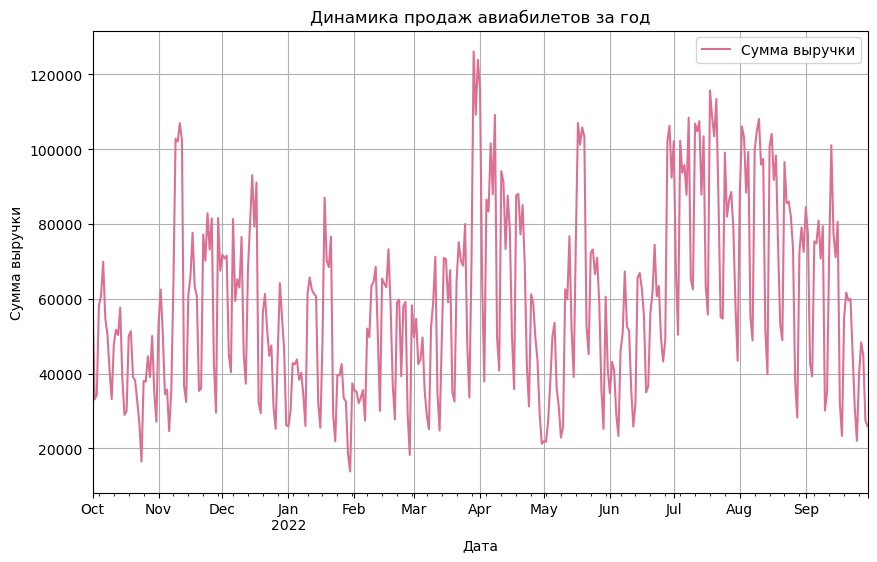

In [37]:
#визуализируем
revenue.plot(grid=True, title='Динамика продаж авиабилетов за год', ylabel='Сумма выручки', xlabel='Дата', figsize=(10,6), x='issue_date', y='revenue_amount', label='Сумма выручки',  color='PaleVioletRed')
plt.show()
#на первый взгляд, больше всего продаж было в какой-то из дней в апреле, видимо, люди готовились к летнему отпуску заранее

**ffp_flag**

In [38]:
#детализируем наш отчет по полю ffp_flag
revenue_ffp = data_new.pivot_table(index='issue_date',
                                   columns='ffp_flag',
                                   aggfunc='sum',
                                   values='revenue_amount').reset_index()
revenue_ffp

ffp_flag,issue_date,False,True
0,2021-10-01,38160,22150
1,2021-10-02,21020,12080
2,2021-10-03,18750,15570
3,2021-10-04,33330,24860
4,2021-10-05,33250,27550
...,...,...,...
360,2022-09-26,30020,9500
361,2022-09-27,37650,10700
362,2022-09-28,28150,16710
363,2022-09-29,21970,5490


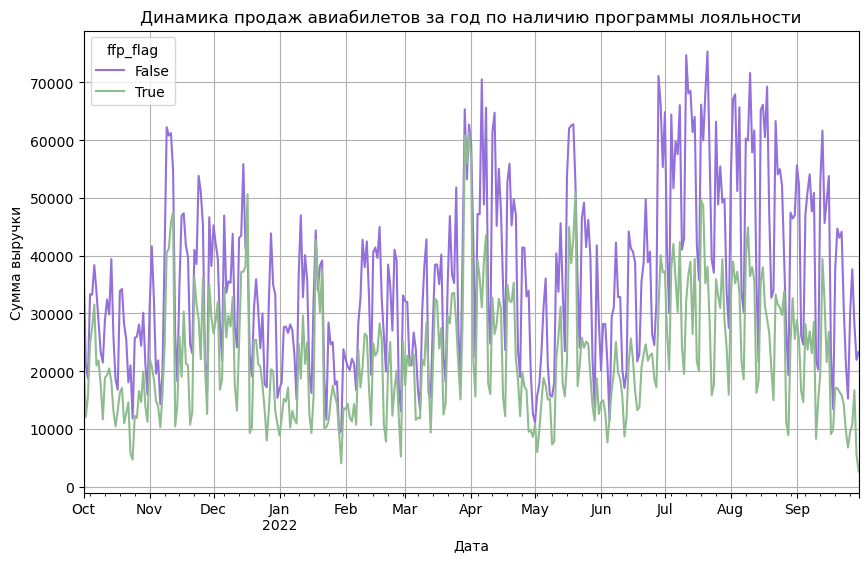

In [39]:
revenue_ffp.plot(grid=True, title='Динамика продаж авиабилетов за год по наличию программы лояльности', ylabel='Сумма выручки', xlabel='Дата', figsize=(10,6), x='issue_date', label=['Нет программы лояльности', 'Есть программа лояльности'],  color=['MediumPurple', 'DarkSeaGreen'])
plt.show()
#видим, что людям без программы лояльности билеты выходили дороже => выручка с них больше

In [40]:
#посмотрим, сколько в целом продаж было по программе лояльности и без нее
data_new['ffp_flag'].value_counts()
#получается, выручка с продаж людям без программы лояльности больше не только из-за более дорогой стоимости билета, но и из-за того, что только у 39% есть программа лояльности

False    30029
True     19336
Name: ffp_flag, dtype: int64

**route_flight_type**

In [41]:
#детализируем по полю route_flight_type
revenue_flight_type = data_new.pivot_table(index='issue_date',
                                           columns='route_flight_type',
                                           aggfunc='sum',
                                           values='revenue_amount').reset_index()
revenue_flight_type 

route_flight_type,issue_date,ВВЛ,МВЛ
0,2021-10-01,45710.0,14600.0
1,2021-10-02,26730.0,6370.0
2,2021-10-03,25940.0,8380.0
3,2021-10-04,48310.0,9880.0
4,2021-10-05,47580.0,13220.0
...,...,...,...
360,2022-09-26,36200.0,3320.0
361,2022-09-27,41900.0,6450.0
362,2022-09-28,31430.0,13430.0
363,2022-09-29,22240.0,5220.0


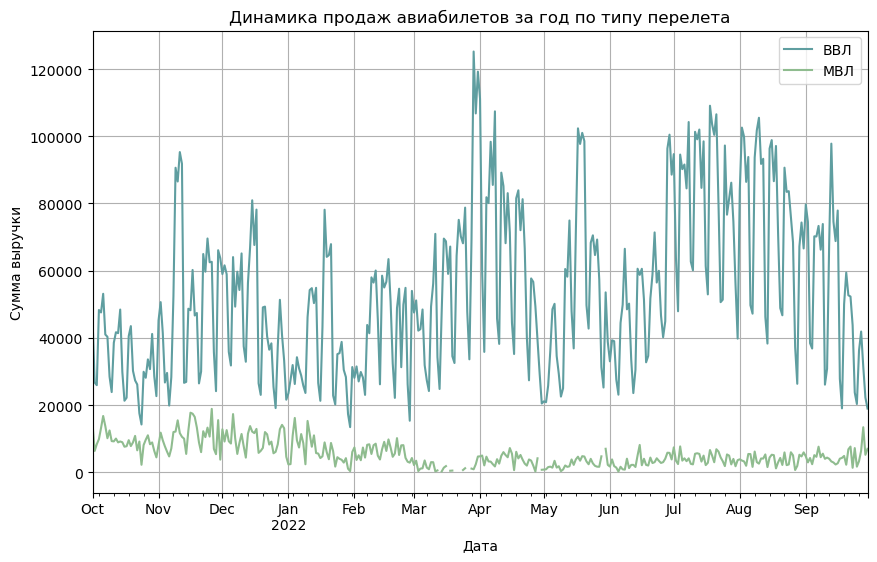

In [42]:
revenue_flight_type.plot(grid=True, title='Динамика продаж авиабилетов за год по типу перелета', ylabel='Сумма выручки', xlabel='Дата', figsize=(10,6), x='issue_date', y=['ВВЛ', 'МВЛ'], label=['ВВЛ', 'МВЛ'],  color=['CadetBlue', 'DarkSeaGreen'])
plt.show()
#международные перелеты в конце 21 года и в 22 году не пользовались популярностью, что наверняка связано с ковидными ограничениями => и выручка от их продажи была значительно меньше, чем от продажи внутренних перелетов

In [43]:
#посмотрим, насколько меньше было продано билетов заграницу, чем внутри страны
data_new['route_flight_type'].value_counts()
#видим, что всего порядка 8% перелетов в 22 году были международными

ВВЛ    45468
МВЛ     3897
Name: route_flight_type, dtype: int64

**sale_type**

In [44]:
#детализируем по полю sale_type
revenue_sale_type = data_new.pivot_table(index='issue_date',
                                         columns='sale_type',
                                         aggfunc='sum',
                                         values='revenue_amount').reset_index()
revenue_sale_type

sale_type,issue_date,OFFLINE,ONLINE
0,2021-10-01,31530,28780
1,2021-10-02,16180,16920
2,2021-10-03,8270,26050
3,2021-10-04,26390,31800
4,2021-10-05,26910,33890
...,...,...,...
360,2022-09-26,22290,17230
361,2022-09-27,27080,21270
362,2022-09-28,25930,18930
363,2022-09-29,18880,8580


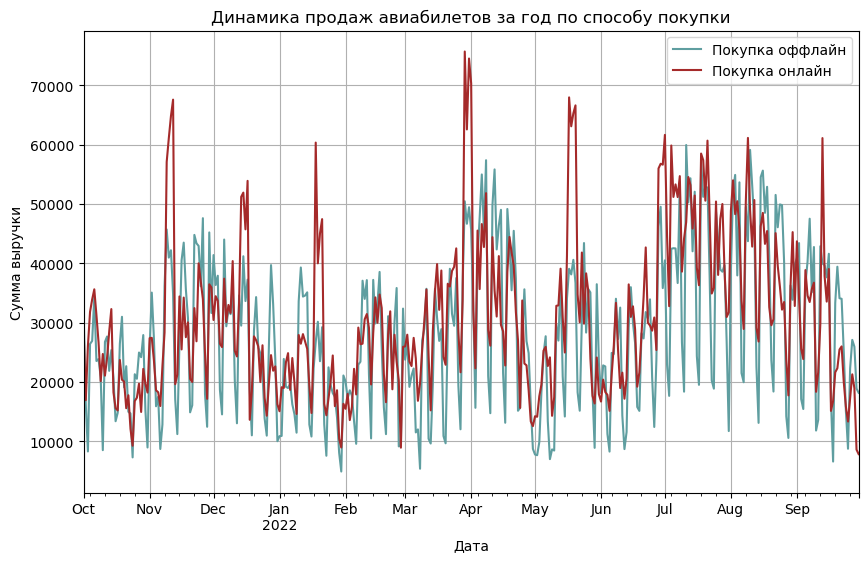

In [45]:
revenue_sale_type.plot(grid=True, title='Динамика продаж авиабилетов за год по способу покупки', ylabel='Сумма выручки', xlabel='Дата', figsize=(10,6), x='issue_date', y=['OFFLINE', 'ONLINE'], label=['Покупка оффлайн', 'Покупка онлайн'],  color=['CadetBlue', 'brown'])
plt.show()
#по динамике видны скачки, когда продажи проходили преимущественно онлайн, возможно тогда билеты онлайн были дешевле (например, есть поверье, что ночью билеты дешевле, чем днем, а в ночи нигде, кроме как онлайн, билеты не найдешь), а возможно это просто совпадение

In [46]:
data_new.groupby('sale_type')['revenue_amount'].sum()
#выручка с продаж онлайн и оффлайн примерно одинакова

sale_type
OFFLINE    10317780
ONLINE     11285910
Name: revenue_amount, dtype: int64

In [47]:
data_new['sale_type'].value_counts()
#количество продаж онлайн незначительно отличается от числа оффлайн продаж

ONLINE     27738
OFFLINE    21627
Name: sale_type, dtype: int64

**pax_type**

In [48]:
#детализируем по полю pax_type
revenue_pax_type = data_new.pivot_table(index='issue_date',
                                        columns='pax_type',
                                        aggfunc='sum',
                                        values='revenue_amount').reset_index()
revenue_pax_type.fillna(0) #не всегда люди летели с ребенком, и не везде покупатель не указан, поэтому пустые значения приравняем к нулевой выручке

pax_type,issue_date,AD,CHD,INF
0,2021-10-01,55550.0,4760.0,0.0
1,2021-10-02,32740.0,360.0,0.0
2,2021-10-03,32070.0,2250.0,0.0
3,2021-10-04,56260.0,1620.0,310.0
4,2021-10-05,56550.0,4250.0,0.0
...,...,...,...,...
360,2022-09-26,38770.0,750.0,0.0
361,2022-09-27,47510.0,840.0,0.0
362,2022-09-28,44440.0,420.0,0.0
363,2022-09-29,24520.0,2940.0,0.0


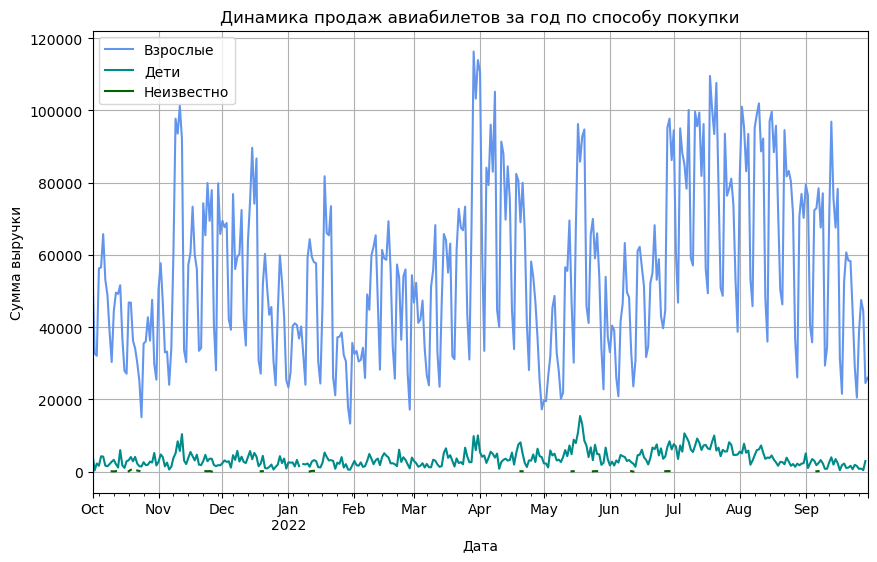

In [49]:
revenue_pax_type.plot(grid=True, title='Динамика продаж авиабилетов за год по способу покупки', ylabel='Сумма выручки', xlabel='Дата', figsize=(10,6), x='issue_date', y=['AD', 'CHD', 'INF'], label=['Взрослые', 'Дети', 'Неизвестно'],  color=['cornflowerblue', 'DarkCyan', 'DarkGreen'])
plt.show()
#чаще всего было известно, что летит взрослый/ребенок, кроме того, взрослые летали гораздо чаще, чем дети => продажи билетов взрослым больше

In [50]:
#посмотрим верно ли наше предположение
data_new['pax_type'].value_counts()
#действительно, количество неидентифицированных пользователей крайне мало, а количество перелетов с детьми составляет всего порядка 7%

AD     45834
CHD     3445
INF       86
Name: pax_type, dtype: int64

<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    - Наибольшая выручка была зафиксирована в апреле 22 года, а наименьшая - в феврале <br>
    - Выручка с продаж людям по программе лояльности в целом меньше выручки с продаж людям без программы лояльности, что предположительно связано со скидками на билеты и меньшим количеством обладателей этой программы <br>
    - Выручка с продаж по внутренним авиалиниям значительно превышает выручку с международных полетов, что наверняка связано с ковидными ограничениями в 22 году <br>
    - Выручка и количество продаж онлайн и оффлайн отличаются незначительно (но выручка и количество продаж онлайн слегка больше) <br>
    - Выручка с продаж взрослым гораздо больше выручки с продаж детям и неидентифицированным пользователям.

[Вернуться к навигации](#15th)

#### <a class="anchor" id="10th"></a> 3.2 Исследование выручки, принятие решения об исключении выбросов для дальнейшего исследования, руководствуясь минимизацией потерь в данных.

In [51]:
revenue_research = data_new['revenue_amount']

Проведем пару тестов на нормальность распределения выручки

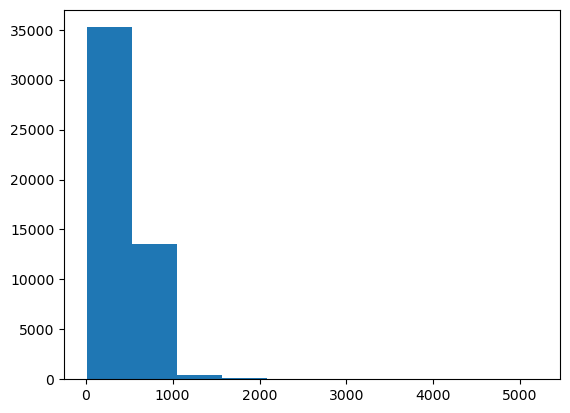

In [52]:
#построим гистограмму
plt.hist(revenue_research)
plt.show()

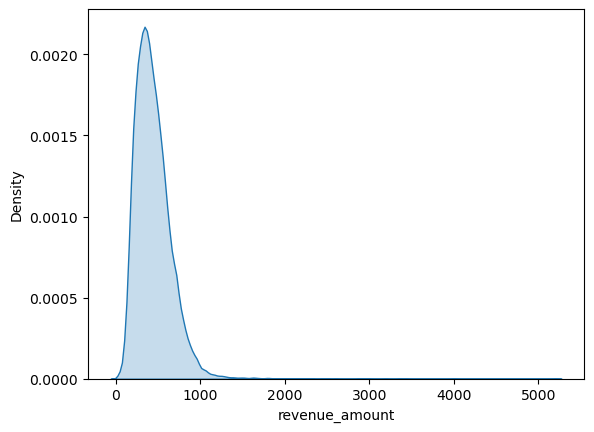

In [53]:
#посмотрим плотность распределения
sns.kdeplot(revenue_research, fill='True')
plt.show()
#наше распределение смещено вправо - не является нормальным

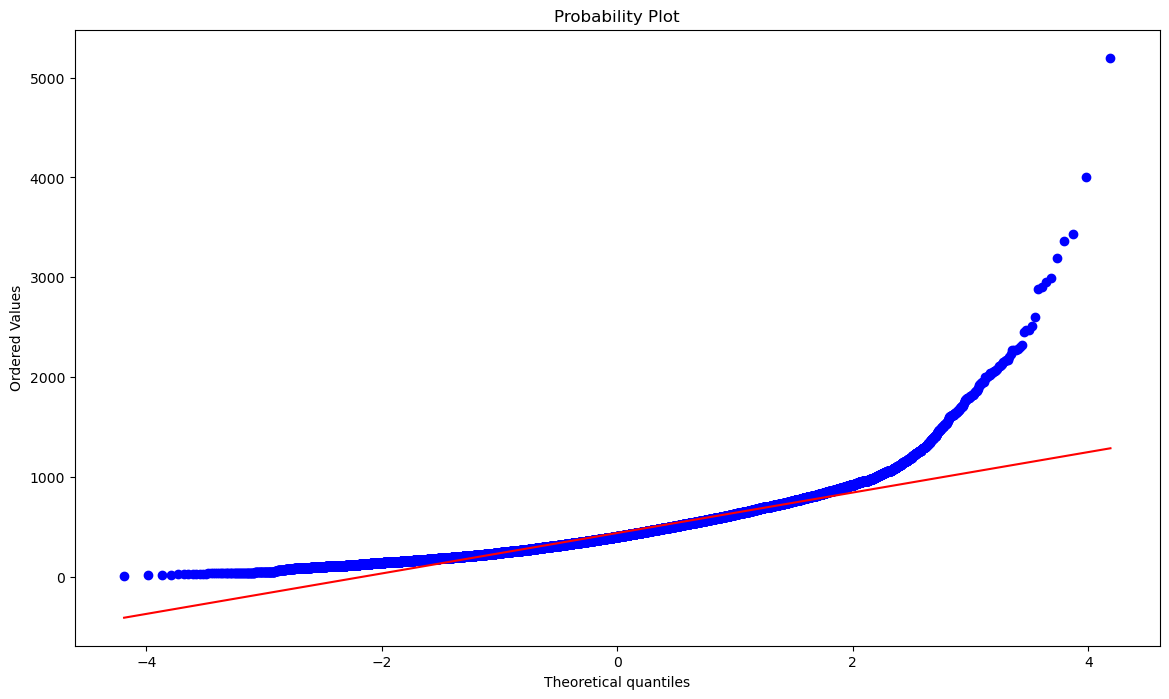

In [54]:
#чтобы в этом убедиться проверим с qq-plot
plt.figure(figsize=(14,8))
st.probplot(revenue_research, dist='norm', plot=plt)
plt.show()
#распределение не похоже на нормальное

Теперь исследуем выбросы

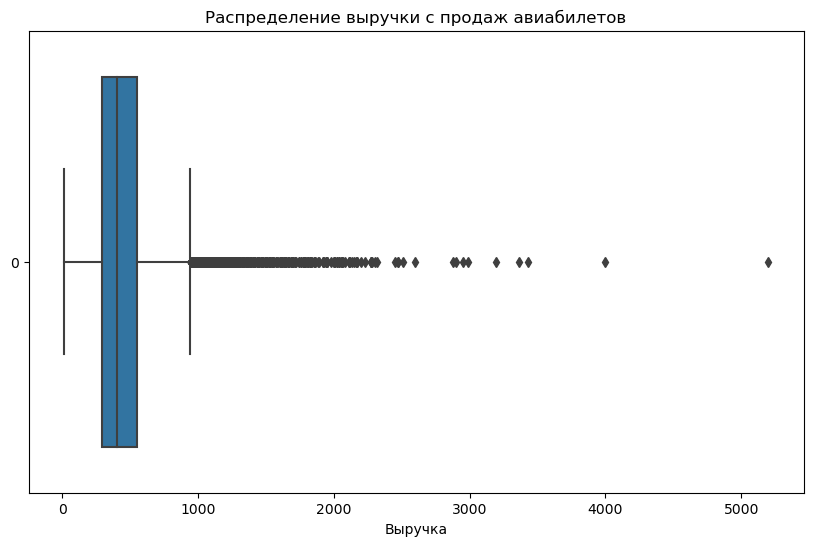

In [55]:
plt.figure(figsize=(10, 6))
 
sns.boxplot(data=revenue_research, orient='h')
 
# подпись и заголовок
plt.xlabel('Выручка')
plt.title('Распределение выручки с продаж авиабилетов')

plt.show()
#видим наши выбросы

In [56]:
revenue_research.describe()
#отметим, что среднее = 437.6, ско = 214.6

count    49365.000000
mean       437.631723
std        214.604891
min         10.000000
25%        290.000000
50%        400.000000
75%        550.000000
max       5200.000000
Name: revenue_amount, dtype: float64

In [57]:
#найдем границы усов
q75 = np.percentile(revenue_research, 75)
q25 = np.percentile(revenue_research, 25)
iqr = q75 - q25
ejection_h = q75 + 1.5*iqr
ejection_l = q25 - 1.5*iqr

print (ejection_h, ejection_l)
#отметим, что нижняя граница отрицательная 

940.0 -100.0


In [58]:
#найдем число выбросов
n_ejection = revenue_research[(revenue_research > ejection_h) | (revenue_research < ejection_l)].count()
print('Число выбросов:', n_ejection)

Число выбросов: 987


In [59]:
#найдем процент выбросов от всего датасета
ejection_perc = ((n_ejection / revenue_research.count()) * 100).round(2)
ejection_perc
#всего 2% выбросов, посмотрим на данные поближе

2.0

In [60]:
data_new[data_new['revenue_amount'] > 940]
#ничего общего между выбросами я не вижу, возможно цена билета связана с плохими погодными условиями/загруженностью рейса и прочими непредсказуемыми факторами

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
14,2022-01-07,2022-01-15,AD,1090,GDZ,MOW,ВВЛ,False,OFFLINE
79,2022-01-07,2022-01-08,AD,1820,OVB,KHV,ВВЛ,False,OFFLINE
117,2021-12-06,2022-01-15,AD,1030,BKK,KHV,МВЛ,True,OFFLINE
164,2021-12-12,2022-01-04,AD,960,MOW,AER,ВВЛ,False,ONLINE
213,2021-12-24,2022-01-02,AD,2000,IKT,MOW,ВВЛ,False,OFFLINE
...,...,...,...,...,...,...,...,...,...
48994,2021-10-16,2021-12-20,AD,1310,VVO,HKT,МВЛ,True,ONLINE
49100,2022-04-15,2022-05-04,AD,960,HTA,MOW,ВВЛ,False,OFFLINE
49191,2022-04-08,2022-05-21,AD,970,VVO,OVB,ВВЛ,True,OFFLINE
49334,2022-06-28,2022-06-30,AD,950,MOW,HTA,ВВЛ,False,OFFLINE


In [61]:
#вернемся к тому, что нижняя граница выбросов отрицательная
#определим границу значений, при percentile = 99.9, чтобы найти экстримальные выбросы
revenue_research_ejection_h = np.percentile(revenue_research, 99)
revenue_research_ejection_h

1070.0

In [62]:
data_new.shape

(49365, 9)

In [63]:
#определим число экстримальных выбросов
revenue_research_count = revenue_research[(revenue_research > revenue_research_ejection_h)].count()
revenue_research_count 

478

In [64]:
#определим процент экстримальных выбросов
ejection_perc1 = ((revenue_research_count / revenue_research.count()) * 100).round(2)
ejection_perc1

0.97

In [65]:
#удалим экстримальные выбросы, переписав датасет
good_data = data_new[(data_new['revenue_amount'] <= revenue_research_ejection_h)].reset_index(drop=True)
good_data

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,2022-01-11,AD,200,MOW,KGD,ВВЛ,False,ONLINE
1,2021-12-31,2022-01-03,AD,610,UUS,OVB,ВВЛ,False,OFFLINE
2,2021-11-28,2022-01-04,AD,390,KGD,MOW,ВВЛ,True,ONLINE
3,2021-12-08,2022-01-05,AD,190,VOZ,MOW,ВВЛ,False,ONLINE
4,2021-12-08,2022-01-12,AD,190,MOW,KRR,ВВЛ,True,OFFLINE
...,...,...,...,...,...,...,...,...,...
48882,2022-06-11,2022-06-22,CHD,480,MOW,OMS,ВВЛ,False,ONLINE
48883,2022-06-06,2022-06-20,AD,270,LED,MOW,ВВЛ,False,OFFLINE
48884,2022-06-26,2022-06-29,AD,230,MOW,KZN,ВВЛ,True,ONLINE
48885,2022-06-26,2022-06-28,AD,270,KZN,MOW,ВВЛ,False,OFFLINE


In [66]:
#посмотрим, как изменилось среднее и ско
good_data.describe()
#среднее = 432.6, ско = 204.7

,revenue_amount
count,48887.000000
mean,427.924193
std,186.981907
min,10.000000
25%,290.000000
50%,400.000000
75%,540.000000
max,1070.000000


<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    1. Распределение выручки не является нормальным <br>
    2. Количество выбросов составляет 2% от датасета
    3. Количество экстримальных выбросов составляет 0,1% от датасета => было принято решение удалить экстримальные выбросы, чтобы минимизировать потери в данных

[Вернуться к навигации](#15th)

#### <a class="anchor" id="11th"></a> 3.3 Исследование сезонности продаж. Дополнительная проверка гипотезы о том, что выручка от продаж осенью и зимой отличается. Исследование выручки и числа продаж по месяцам, проверка корреляции.

In [67]:
#для исследования сезонности добавим в датасет столбец с месяцами покупки
mounth = pd.DatetimeIndex(good_data['issue_date']).month 
good_data.insert(loc = 1, column = 'mounth', value = mounth)
good_data

,issue_date,mounth,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,2022-01-11,AD,200,MOW,KGD,ВВЛ,False,ONLINE
1,2021-12-31,12,2022-01-03,AD,610,UUS,OVB,ВВЛ,False,OFFLINE
2,2021-11-28,11,2022-01-04,AD,390,KGD,MOW,ВВЛ,True,ONLINE
3,2021-12-08,12,2022-01-05,AD,190,VOZ,MOW,ВВЛ,False,ONLINE
4,2021-12-08,12,2022-01-12,AD,190,MOW,KRR,ВВЛ,True,OFFLINE
...,...,...,...,...,...,...,...,...,...,...
48882,2022-06-11,6,2022-06-22,CHD,480,MOW,OMS,ВВЛ,False,ONLINE
48883,2022-06-06,6,2022-06-20,AD,270,LED,MOW,ВВЛ,False,OFFLINE
48884,2022-06-26,6,2022-06-29,AD,230,MOW,KZN,ВВЛ,True,ONLINE
48885,2022-06-26,6,2022-06-28,AD,270,KZN,MOW,ВВЛ,False,OFFLINE


In [68]:
#для удобства обозначим месяца
dict_mounth = {1: 'january',
               2: 'february',
               3: 'march',
               4: 'april',
               5: 'may',
               6: 'june',
               7: 'july',
               8: 'august',
               9: 'september',
              10: 'october',
              11: 'november',
              12: 'december'}

In [69]:
mounth_name = good_data['mounth'].map(dict_mounth)
good_data.insert(loc = 2, column = 'mounth_name', value = mounth_name)
good_data

,issue_date,mounth,mounth_name,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,december,2022-01-11,AD,200,MOW,KGD,ВВЛ,False,ONLINE
1,2021-12-31,12,december,2022-01-03,AD,610,UUS,OVB,ВВЛ,False,OFFLINE
2,2021-11-28,11,november,2022-01-04,AD,390,KGD,MOW,ВВЛ,True,ONLINE
3,2021-12-08,12,december,2022-01-05,AD,190,VOZ,MOW,ВВЛ,False,ONLINE
4,2021-12-08,12,december,2022-01-12,AD,190,MOW,KRR,ВВЛ,True,OFFLINE
...,...,...,...,...,...,...,...,...,...,...,...
48882,2022-06-11,6,june,2022-06-22,CHD,480,MOW,OMS,ВВЛ,False,ONLINE
48883,2022-06-06,6,june,2022-06-20,AD,270,LED,MOW,ВВЛ,False,OFFLINE
48884,2022-06-26,6,june,2022-06-29,AD,230,MOW,KZN,ВВЛ,True,ONLINE
48885,2022-06-26,6,june,2022-06-28,AD,270,KZN,MOW,ВВЛ,False,OFFLINE


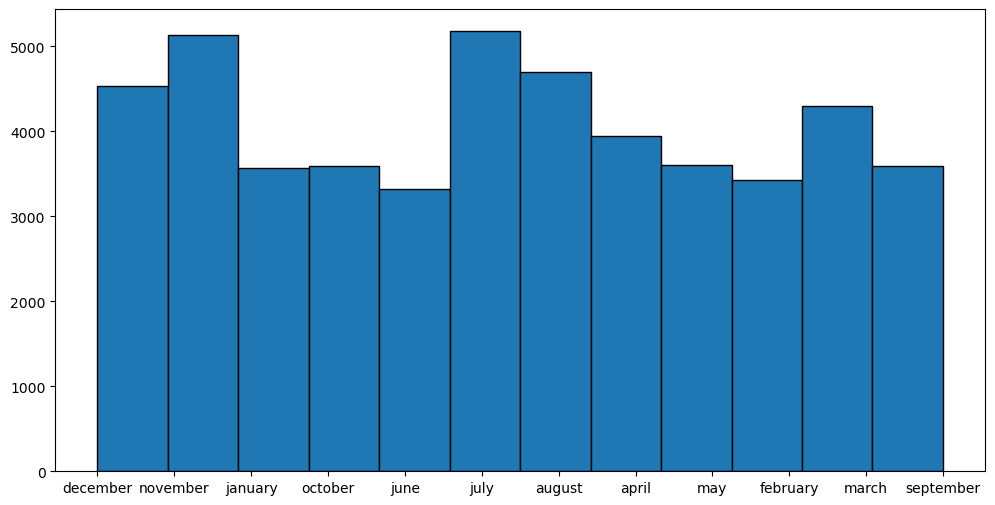

In [70]:
#построим гистограмму
plt.figure(figsize=(12, 6))
plt.hist(mounth_name, edgecolor='black', bins=12) 
plt.show()
#по месяцам не особо понятно, в какой сезон билеты покупались чаще

In [71]:
#добавим категоризацию данных для изучения сезонности
def season(counts):
    if counts == 12 or 1<= counts <= 2:
        return 'winter'
    elif 3 <= counts <= 5:
        return 'spring' 
    elif 6 <= counts <= 8:
        return 'summer'
    else:
        return 'autumn'

In [72]:
season_name = good_data['mounth'].apply(season)
good_data.insert(loc = 3, column = 'season_name', value = season_name)
good_data

,issue_date,mounth,mounth_name,season_name,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,december,winter,2022-01-11,AD,200,MOW,KGD,ВВЛ,False,ONLINE
1,2021-12-31,12,december,winter,2022-01-03,AD,610,UUS,OVB,ВВЛ,False,OFFLINE
2,2021-11-28,11,november,autumn,2022-01-04,AD,390,KGD,MOW,ВВЛ,True,ONLINE
3,2021-12-08,12,december,winter,2022-01-05,AD,190,VOZ,MOW,ВВЛ,False,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,AD,190,MOW,KRR,ВВЛ,True,OFFLINE
...,...,...,...,...,...,...,...,...,...,...,...,...
48882,2022-06-11,6,june,summer,2022-06-22,CHD,480,MOW,OMS,ВВЛ,False,ONLINE
48883,2022-06-06,6,june,summer,2022-06-20,AD,270,LED,MOW,ВВЛ,False,OFFLINE
48884,2022-06-26,6,june,summer,2022-06-29,AD,230,MOW,KZN,ВВЛ,True,ONLINE
48885,2022-06-26,6,june,summer,2022-06-28,AD,270,KZN,MOW,ВВЛ,False,OFFLINE


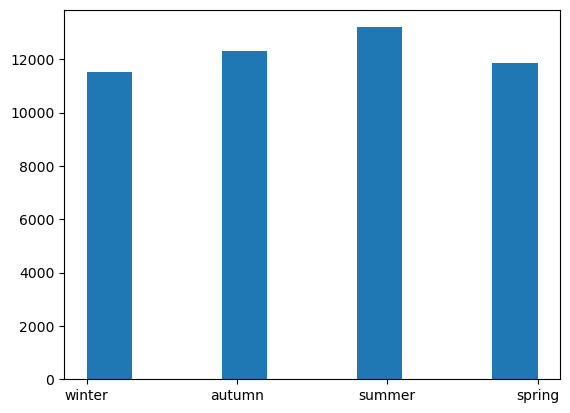

In [73]:
#построим гистограмму
plt.hist(season_name)
plt.show()
#после категоризации видно, что чаще всего билеты покупались летом

**Проверим гипотезу** <br>
Н0: выручка от продаж осенью равна выручке от продаж зимой <br>
Н1: выручка от продаж осенью не равна выручке от продаж зимой <br>

Но сначала рассмотрим распределение выручки зимой и летом

In [74]:
revenue_autumn = good_data[good_data['season_name'] == "autumn"]['revenue_amount']
revenue_winter = good_data[good_data['season_name'] == "winter"]['revenue_amount']

<Axes: >

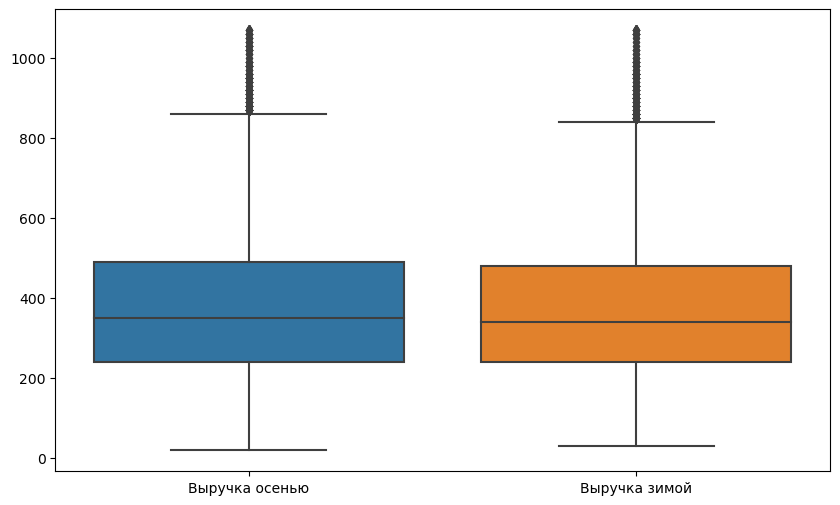

In [75]:
revenue_a_w = pd.DataFrame({'Выручка осенью': revenue_autumn, 'Выручка зимой':revenue_winter})

plt.figure(figsize = (10, 6))

sns.boxplot(revenue_a_w)

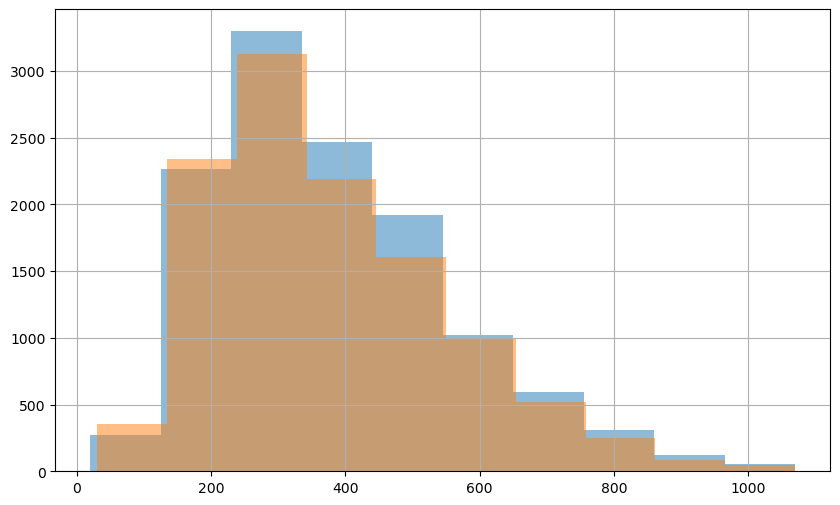

In [76]:
plt.figure(figsize = (10, 6))

plt.hist(revenue_autumn, bins=10, label='Выручка осенью', alpha=0.5)
plt.hist(revenue_winter, bins=10, label='Выручка зимой', alpha=0.5)

plt.grid(True)

plt.show()

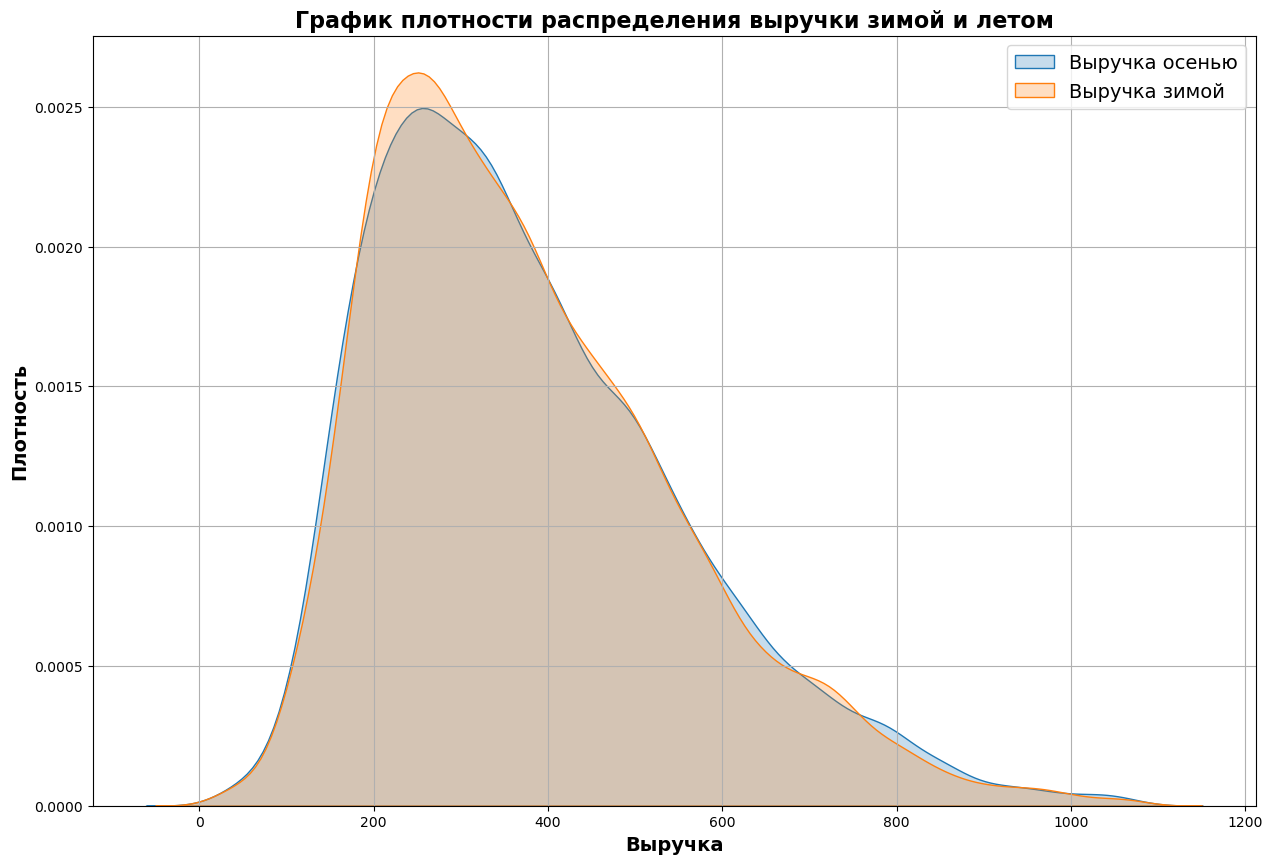

In [77]:
#посмотрим плотность распределения
plt.figure(figsize=(15, 10))

sns.kdeplot(revenue_autumn, fill=True, label='Выручка осенью')
sns.kdeplot(revenue_winter, fill=True, label='Выручка зимой')

plt.xlabel('Выручка', fontsize=14, fontweight="bold")
plt.ylabel('Плотность', fontsize=14, fontweight="bold")
plt.title('График плотности распределения выручки зимой и летом', fontsize=16, fontweight="bold")
plt.grid(True)
plt.legend(fontsize=14)

plt.show()
#на первый взгляд выручки не имеют нормального распределения

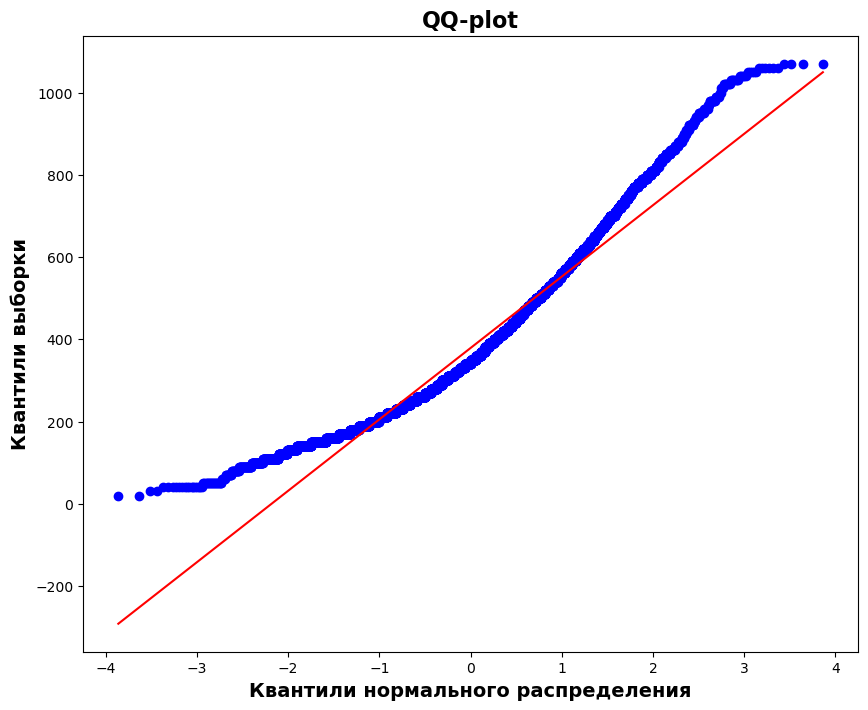

In [78]:
#проверим на нормальность распределение выручки осенью с помощью qq-plot
plt.figure(figsize=(10, 8))

st.probplot(revenue_autumn, dist='norm', plot=plt)
plt.title('QQ-plot', fontsize=16, fontweight="bold")
plt.xlabel('Квантили нормального распределения', fontsize=14, fontweight="bold")
plt.ylabel('Квантили выборки', fontsize=14, fontweight="bold")
plt.show()

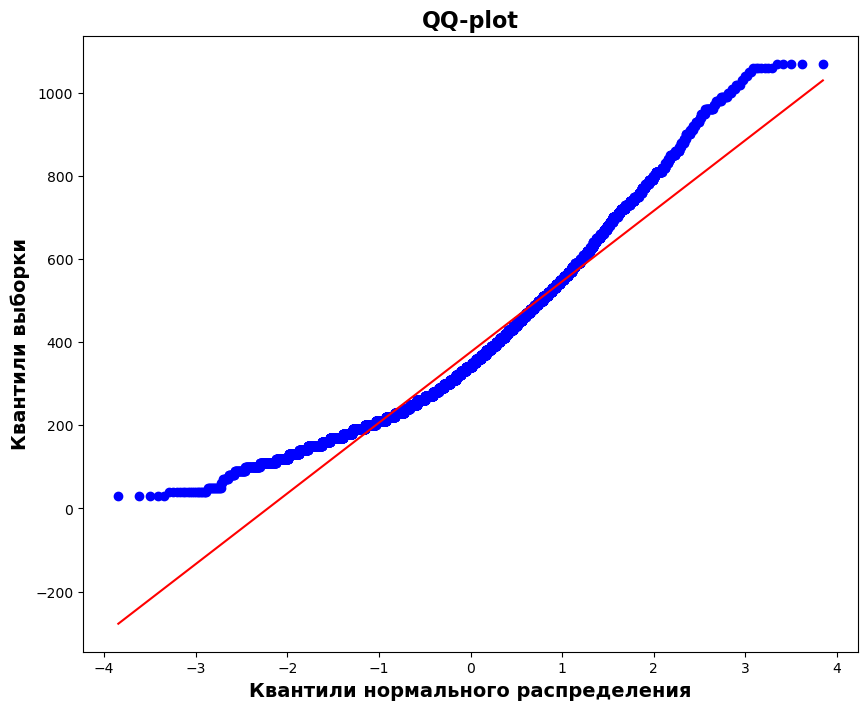

In [79]:
#проверим на нормальность распределение выручки зимой с помощью qq-plot
plt.figure(figsize=(10, 8))

st.probplot(revenue_winter, dist='norm', plot=plt)
plt.title('QQ-plot', fontsize=16, fontweight="bold")
plt.xlabel('Квантили нормального распределения', fontsize=14, fontweight="bold")
plt.ylabel('Квантили выборки', fontsize=14, fontweight="bold")
plt.show()

Выручка зимой и осенью не имеет нормального распределения, поэтому проведем тест Манна-Уитни, чтобы сравнить выборки и проверить гипотезы

Н0: выручка от продаж осенью равна выручке от продаж зимой <br>
Н1: выручка от продаж осенью не равна выручке от продаж зимой <br>

In [80]:
alfa = 0.05

from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(revenue_autumn, revenue_winter)

if p_value <= alfa:
    print('Отвергаем нулевую гипотезу: Выручка от продаж осенью не равна выручке от продаж зимой')
else:
    print('Не можем отвергнуть нулевую гипотезу: Выручка от продаж осенью равна выручке от продаж зимой')

Не можем отвергнуть нулевую гипотезу: Выручка от продаж осенью равна выручке от продаж зимой


Исследуем выручку по месяцам

In [81]:
revenue_amount_season = good_data.pivot_table(index='season_name',
                                              aggfunc='sum',
                                              values='revenue_amount')
revenue_amount_season

,revenue_amount
season_name,
autumn,4667060
spring,5465360
summer,6451920
winter,4335590


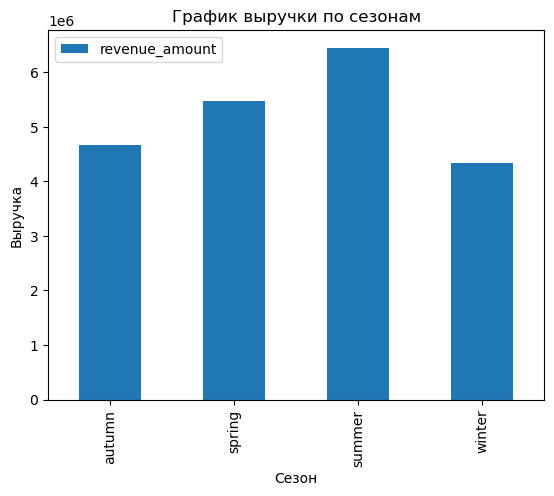

In [82]:
revenue_amount_season.plot(kind = 'bar', title='График выручки по сезонам', ylabel='Выручка', xlabel='Сезон')
plt.show()
#летом была наибольшая выручка, а зимой - наименьшая

In [83]:
#укрупним по месяцам - будем использовать номера, чтобы избежать путанницы по порядку месяцев
revenue_amount_mounth = good_data.pivot_table(index='mounth',
                                              aggfunc='sum',
                                              values='revenue_amount')
revenue_amount_mounth

,revenue_amount
mounth,
1,1318080
2,1310660
3,1779820
4,1990440
5,1695100
6,1576160
7,2532670
8,2343090
9,1582020


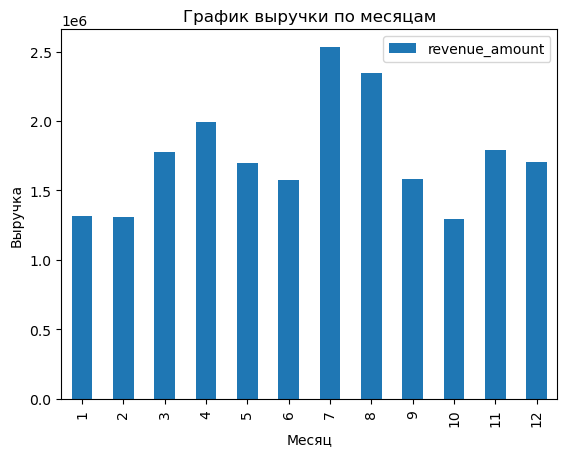

In [84]:
revenue_amount_mounth.plot(kind = 'bar', y='revenue_amount', title='График выручки по месяцам', ylabel='Выручка', xlabel='Месяц')
plt.show()
#в июле была наибольшая выручка, а в январе, феврале и октябре - наименьшая

Исследуем число продаж по месяцам

In [85]:
revenue_count_season = good_data.pivot_table(index='season_name',
                                             aggfunc='count',
                                             values='revenue_amount')
revenue_count_season 

,revenue_amount
season_name,
autumn,12319
spring,11847
summer,13196
winter,11525


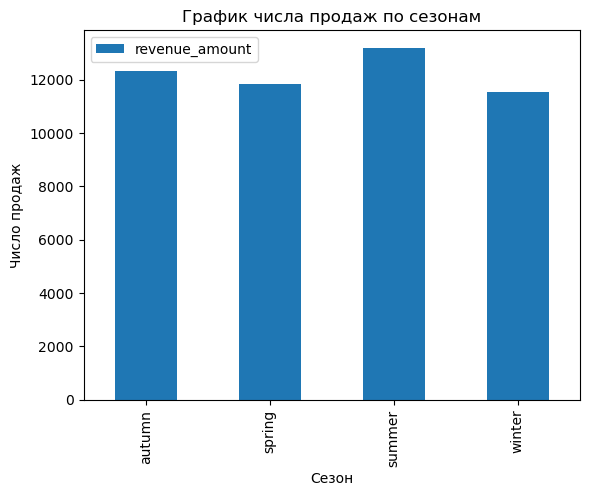

In [86]:
revenue_count_season.plot(kind = 'bar', title='График числа продаж по сезонам', ylabel='Число продаж', xlabel='Сезон')
plt.show()
#летом было больше всего продаж, а зимой - меньше всего

In [87]:
#укрупним по месяцам
revenue_count_mounth = good_data.pivot_table(index='mounth',
                                             aggfunc='count',
                                             values='revenue_amount')
revenue_count_mounth

,revenue_amount
mounth,
1,3566
2,3428
3,4295
4,3944
5,3608
6,3325
7,5178
8,4693
9,3594


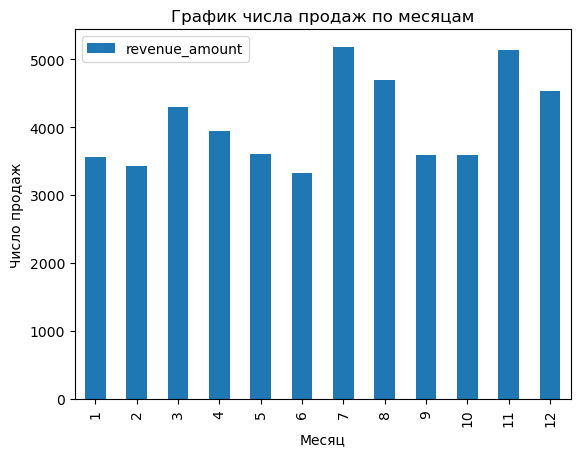

In [88]:
revenue_count_mounth.plot(kind = 'bar', title='График числа продаж по месяцам', ylabel='Число продаж', xlabel='Месяц')
plt.show()
#в июле было больше всего продаж, а в июне меньше всего (немного странно)

Проверим корреляцию

In [89]:
revenue_amount_mounth['count'] = revenue_count_mounth
revenue_amount_mounth.reset_index()

,mounth,revenue_amount,count
0,1,1318080,3566
1,2,1310660,3428
2,3,1779820,4295
3,4,1990440,3944
4,5,1695100,3608
5,6,1576160,3325
6,7,2532670,5178
7,8,2343090,4693
8,9,1582020,3594
9,10,1292940,3591


In [90]:
revenue_amount_mounth['revenue_amount'].corr(revenue_amount_mounth['count'])
#это значит, что между выручкой и числом продаж - высокая и прямая связь

0.7634756869003833

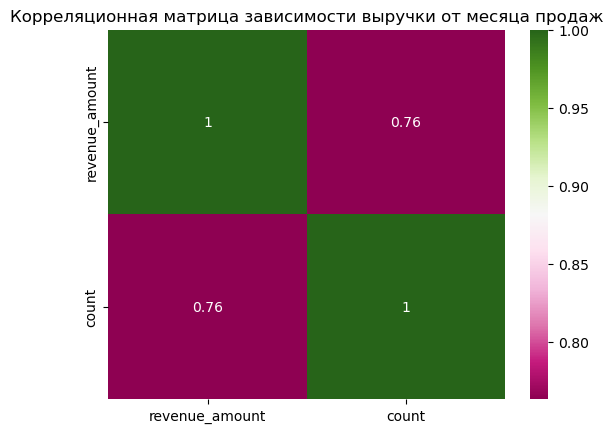

In [91]:
#построим матрицу корреляций
sns.heatmap(revenue_amount_mounth.corr(), annot=True, cmap='PiYG')
plt.title('Корреляционная матрица зависимости выручки от месяца продаж')
plt.show()

<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    1. Выручка от продаж осенью отличается от выручки от продаж зимой. <br>
    2. Летом была наибольшая выручка, а зимой - наименьшая. <br>
    3. В июле была наибольшая выручка, а в январе, феврале и октябре - наименьшая. <br>
    4. Летом было больше всего продаж, а зимой - меньше всего, как и при исследовании выручки. <br>
    5. В июле было больше всего продаж, а в июне меньше всего. Возможно это связано с тем, что в июне билетов остается меньше, а цена на них повышена. В июле же все берут билеты домой с отпусков + покупают билеты на зимовку, например. 
    6. Связь между выручкой и числом продаж высокая и положительная, т.е чем больше продаж в месяце - тем больше выручка за месяц.

[Вернуться к навигации](#15th)

#### <a class="anchor" id="12th"></a> 3.4 Клиенты покупают билеты в разное время. Кто-то покупает билеты заранее, другие - в последний момент. Проверка гипотезы о том, что выручка от продажи билетов для этих двух групп клиентов отличается. Предварительное разбиение клиентов минимум на три группы.

In [92]:
#посмотрим за сколько дней люди покупают билеты
time_to_buy = (good_data['flight_date_loc'] - good_data['issue_date']).dt.days.astype('int64')
time_to_buy

0        35
1         3
2        37
3        28
4        35
         ..
48882    11
48883    14
48884     3
48885     2
48886    16
Length: 48887, dtype: int64

In [93]:
time_to_buy.min()

0

In [94]:
time_to_buy.max()

317

In [95]:
#для внесения данных в таблицу проведем категоризацию
def time(counts):
    if counts == 0 :
         return 'at the last moment'
    elif 1 <= counts <= 2:
        return 'almost at the last moment' 
    elif 3 <= counts <= 14:
        return 'in advance'
    else:
        return 'strongly in advance'

In [96]:
#внесем данные в таблицу
time_name = time_to_buy.apply(time)
good_data.insert(loc = 5, column = 'time_name', value = time_name)
good_data

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,200,MOW,KGD,ВВЛ,False,ONLINE
1,2021-12-31,12,december,winter,2022-01-03,in advance,AD,610,UUS,OVB,ВВЛ,False,OFFLINE
2,2021-11-28,11,november,autumn,2022-01-04,strongly in advance,AD,390,KGD,MOW,ВВЛ,True,ONLINE
3,2021-12-08,12,december,winter,2022-01-05,strongly in advance,AD,190,VOZ,MOW,ВВЛ,False,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,190,MOW,KRR,ВВЛ,True,OFFLINE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48882,2022-06-11,6,june,summer,2022-06-22,in advance,CHD,480,MOW,OMS,ВВЛ,False,ONLINE
48883,2022-06-06,6,june,summer,2022-06-20,in advance,AD,270,LED,MOW,ВВЛ,False,OFFLINE
48884,2022-06-26,6,june,summer,2022-06-29,in advance,AD,230,MOW,KZN,ВВЛ,True,ONLINE
48885,2022-06-26,6,june,summer,2022-06-28,almost at the last moment,AD,270,KZN,MOW,ВВЛ,False,OFFLINE


In [97]:
#посмотрим на выручку по полученным группам клиентов
revenue_time = good_data.pivot_table(index='time_name',
                                     aggfunc='sum',
                                     values='revenue_amount')
revenue_time

,revenue_amount
time_name,
almost at the last moment,3170450
at the last moment,505730
in advance,8990450
strongly in advance,8253300


**Проверим гипотезу** <br>
Н0: выручка от продажи людям, что покупают билеты заранее равна выручке от продажи людям, что покупают билеты в последний момент <br>
Н1: выручка от продажи людям, что покупают билеты заранее не равна выручке от продажи людям, что покупают билеты в последний момент <br>

Но сначала проверим распределение

In [98]:
#в проведенной категоризации есть промежуточное деление - когда люди покупали былеты за 1-2 дня до полета. Я не отношу это к 'заранее', и не отношу к 'в последний момент'. Скорее это 'почти в последний момент', поэтому сравнивать я буду категории именно 'заранее' и 'в последний момент'
revenue_last_moment = good_data[good_data['time_name'] == "at the last moment"]['revenue_amount']
revenue_advance = good_data[good_data['time_name'] == "in advance"]['revenue_amount']

<Axes: >

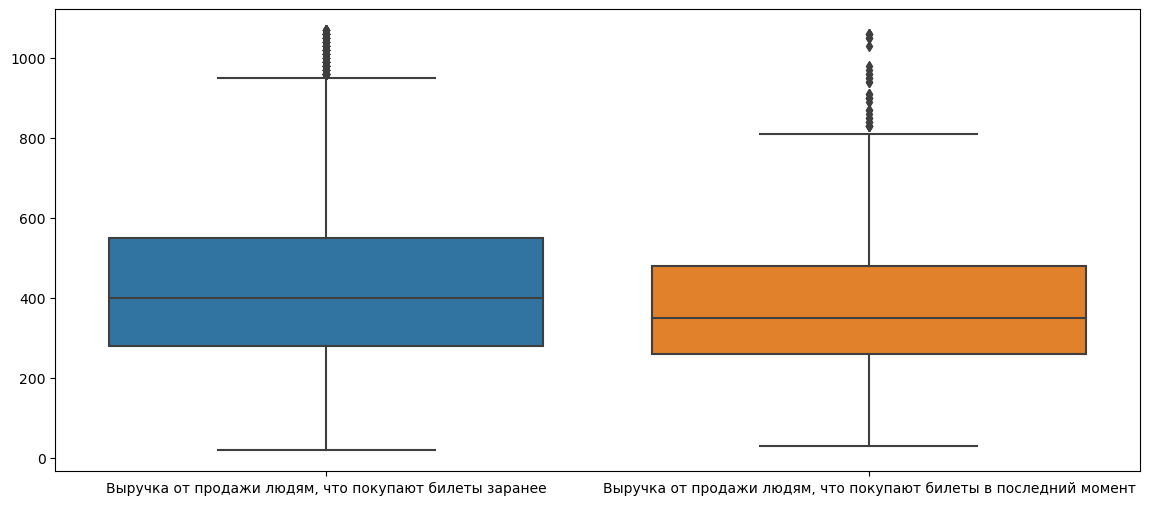

In [136]:
revenue_a_l = pd.DataFrame({'Выручка от продажи людям, что покупают билеты заранее': revenue_advance, 'Выручка от продажи людям, что покупают билеты в последний момент':revenue_last_moment})

plt.figure(figsize = (14, 6))

sns.boxplot(revenue_a_l)

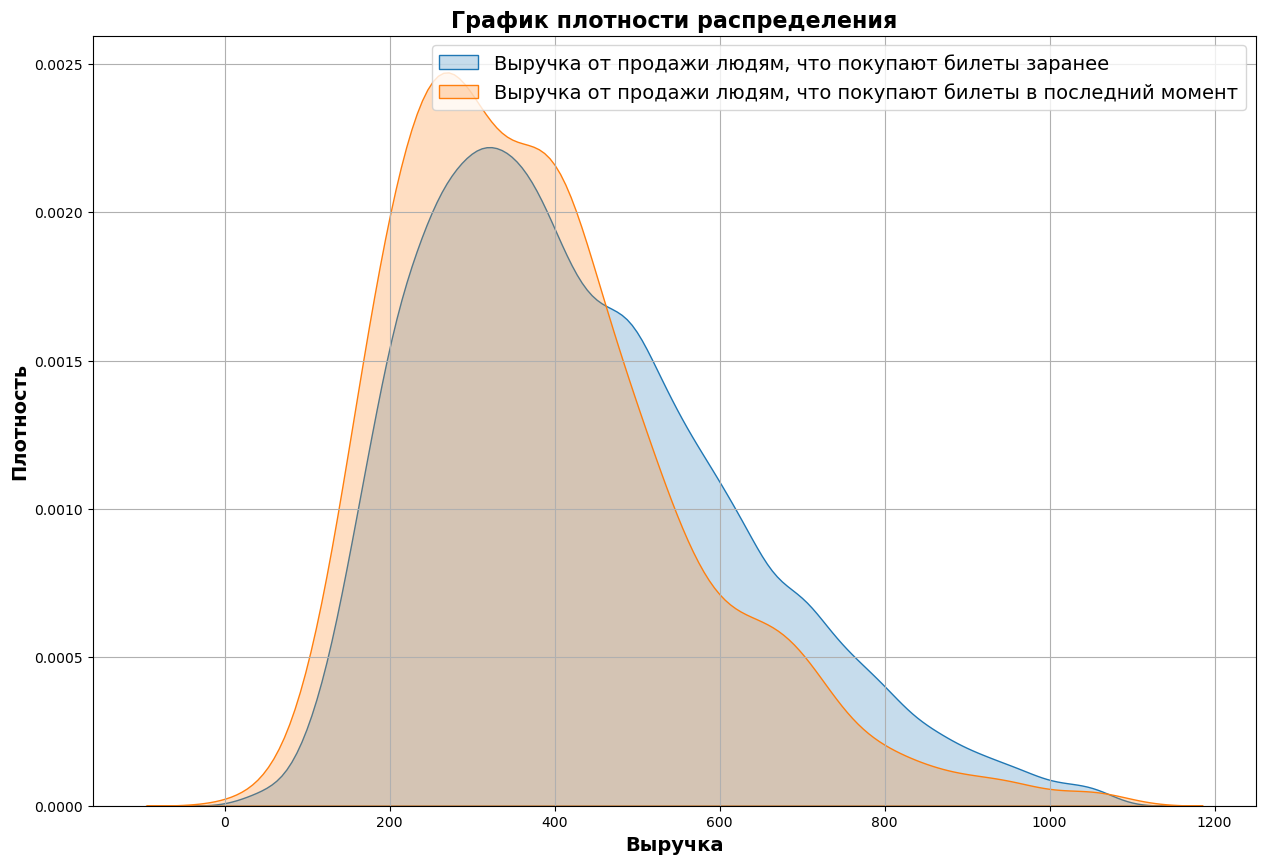

In [139]:
#посмотрим плотность распределения
plt.figure(figsize=(15, 10))

sns.kdeplot(revenue_advance, fill=True, label='Выручка от продажи людям, что покупают билеты заранее')
sns.kdeplot(revenue_last_moment, fill=True, label='Выручка от продажи людям, что покупают билеты в последний момент')

plt.xlabel('Выручка', fontsize=14, fontweight="bold")
plt.ylabel('Плотность', fontsize=14, fontweight="bold")
plt.title('График плотности распределения', fontsize=16, fontweight="bold")
plt.grid(True)
plt.legend(fontsize=14)

plt.show()
#на первый взгляд выручки не имеют нормального распределения

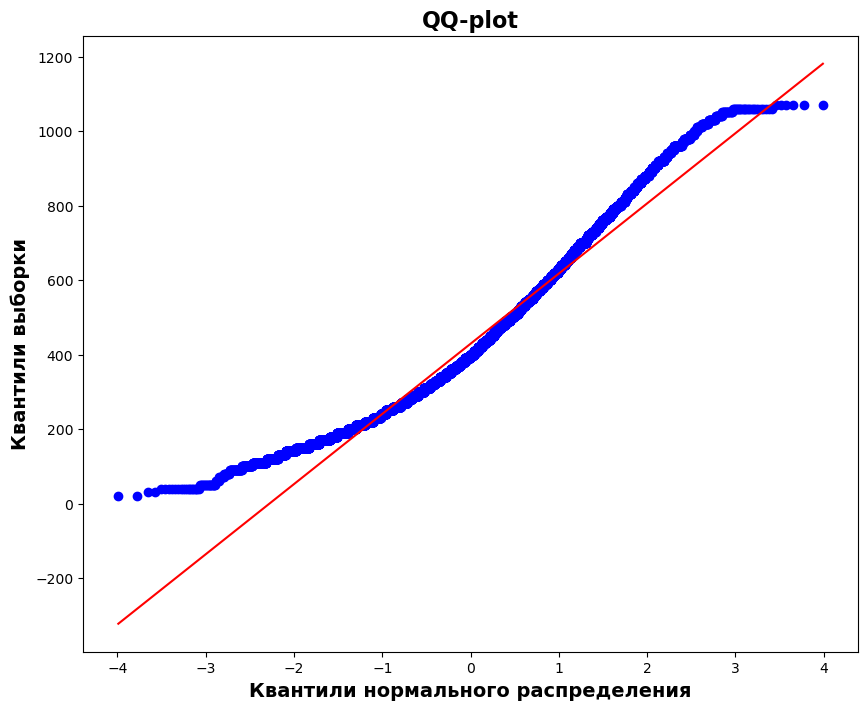

In [138]:
#проверим на нормальность распределение выручки от продажи людям, что покупают билеты заранее с помощью qq-plot
plt.figure(figsize=(10, 8))

st.probplot(revenue_advance, dist='norm', plot=plt)
plt.title('QQ-plot', fontsize=16, fontweight="bold")
plt.xlabel('Квантили нормального распределения', fontsize=14, fontweight="bold")
plt.ylabel('Квантили выборки', fontsize=14, fontweight="bold")
plt.show()

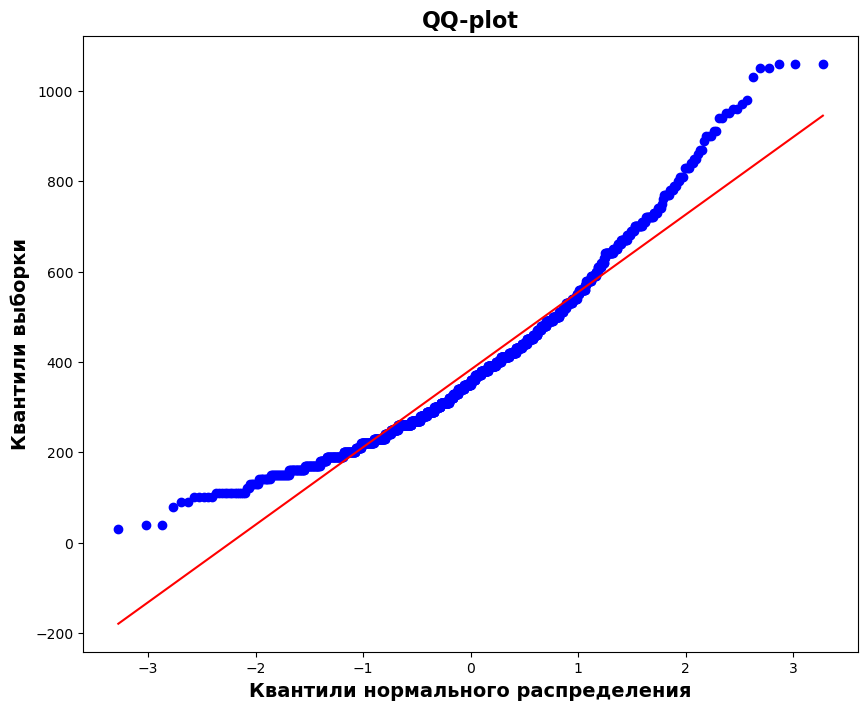

In [140]:
#проверим на нормальность распределение выручки от продажи людям, что покупают билеты в последний момент с помощью qq-plot
plt.figure(figsize=(10, 8))

st.probplot(revenue_last_moment, dist='norm', plot=plt)
plt.title('QQ-plot', fontsize=16, fontweight="bold")
plt.xlabel('Квантили нормального распределения', fontsize=14, fontweight="bold")
plt.ylabel('Квантили выборки', fontsize=14, fontweight="bold")
plt.show()

Мы убедились в том, что выручки не имеют нормального распределения, поэтому сравнивать их будем с помощью теста Манна-Уитни

Н0: выручка от продажи людям, что покупают билеты заранее равна выручке от продажи людям, что покупают билеты в последний момент <br>
Н1: выручка от продажи людям, что покупают билеты заранее не равна выручке от продажи людям, что покупают билеты в последний момент <br>

In [141]:
alfa = 0.05

from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(revenue_advance, revenue_last_moment)

if p_value <= alfa:
    print('Отвергаем нулевую гипотезу: Выручка от продажи людям, что покупают билеты заранее не равна выручке от продажи людям, что покупают билеты в последний момент')
else:
    print('Не можем отвергнуть нулевую гипотезу: Выручка от продажи людям, что покупают билеты заранее равна выручке от продажи людям, что покупают билеты в последний момент')

Отвергаем нулевую гипотезу: Выручка от продажи людям, что покупают билеты заранее не равна выручке от продажи людям, что покупают билеты в последний момент


<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    1. Разделили людей по времени покупки билетов на 4 группы: <br>
    - те, кто покупает билеты сильно заранее<br>
    - те, кто покупает билеты заранее<br>
    - те, кто покупает билеты почти в последний момент<br>
    - те, кто покупает билеты в последний момент<br>
    2. Выяснили, что выручка от продажи билетов двум группам людей (заранее покупающим и покупающим в последний момент) отличается.

[Вернуться к навигации](#15th)

#### <a class="anchor" id="13th"></a> 3.5 Определение топ-10 популярных направлений перелета (город-город) отдельно для ВВЛ и МВЛ. Изучение выручки для этих направлений. Добавление для этого в датасет сведения о городах, используя данные из датасета: https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat

In [101]:
good_data.head(5)

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,200,MOW,KGD,ВВЛ,False,ONLINE
1,2021-12-31,12,december,winter,2022-01-03,in advance,AD,610,UUS,OVB,ВВЛ,False,OFFLINE
2,2021-11-28,11,november,autumn,2022-01-04,strongly in advance,AD,390,KGD,MOW,ВВЛ,True,ONLINE
3,2021-12-08,12,december,winter,2022-01-05,strongly in advance,AD,190,VOZ,MOW,ВВЛ,False,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,190,MOW,KRR,ВВЛ,True,OFFLINE


In [102]:
#импортируем сведения о городах
column_names = ['Airport Name', 'Location', 'Country', 'IATA_Code', 'ICAO_Code', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Timezone Region', 'Type', 'Source']

city = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', names = column_names)
city.head(5)

,Airport Name,Location,Country,IATA_Code,ICAO_Code,Latitude,Longitude,Altitude,Timezone,DST,Timezone Region,Type,Source
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [103]:
#добавим сведения о городах в наш датасет
city_names = city.set_index('IATA_Code')['Location'].to_dict()

orig_city_name = good_data['orig_city_code'].map(city_names)
dest_city_name = good_data['dest_city_code'].map(city_names)

good_data.insert(loc = 9, column = 'orig_city_name', value = orig_city_name)
good_data.insert(loc = 11, column = 'dest_city_name', value = dest_city_name)

good_data.head(5)

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,revenue_amount,orig_city_code,orig_city_name,dest_city_code,dest_city_name,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,200,MOW,NaN,KGD,Kaliningrad,ВВЛ,False,ONLINE
1,2021-12-31,12,december,winter,2022-01-03,in advance,AD,610,UUS,Yuzhno-sakhalinsk,OVB,Novosibirsk,ВВЛ,False,OFFLINE
2,2021-11-28,11,november,autumn,2022-01-04,strongly in advance,AD,390,KGD,Kaliningrad,MOW,NaN,ВВЛ,True,ONLINE
3,2021-12-08,12,december,winter,2022-01-05,strongly in advance,AD,190,VOZ,Voronezh,MOW,NaN,ВВЛ,False,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,190,MOW,NaN,KRR,Krasnodar,ВВЛ,True,OFFLINE


In [104]:
#посмотрим, не потерялось ли ничего в процессе объединения
good_data[good_data['orig_city_name'].isna()]['orig_city_code'].unique()

array(['MOW', 'PAR', 'BAK', 'ROM', 'SEL', 'BER', 'GRV',
       'No data available', 'NQZ', 'OHH', 'TOX', 'MIL', 'TYO', 'LON'],
      dtype=object)

In [105]:
good_data[good_data['orig_city_name'].isna()].head(5)

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,revenue_amount,orig_city_code,orig_city_name,dest_city_code,dest_city_name,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,200,MOW,NaN,KGD,Kaliningrad,ВВЛ,False,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,190,MOW,NaN,KRR,Krasnodar,ВВЛ,True,OFFLINE
5,2021-11-29,11,november,autumn,2022-01-14,strongly in advance,AD,250,MOW,NaN,DUS,Duesseldorf,МВЛ,False,ONLINE
6,2021-12-03,12,december,winter,2022-01-06,strongly in advance,AD,200,MOW,NaN,PEE,Perm,ВВЛ,True,ONLINE
7,2021-11-28,11,november,autumn,2022-01-07,strongly in advance,CHD,70,MOW,NaN,AER,Sochi,ВВЛ,True,ONLINE


In [106]:
#распишем потеряные значения
good_data.loc[good_data['orig_city_code'] == 'MOW', 'orig_city_name'] = 'Moscow'
good_data.loc[good_data['orig_city_code'] == 'PAR', 'orig_city_name'] = 'Paris'
good_data.loc[good_data['orig_city_code'] == 'BAK', 'orig_city_name'] = 'Baku'
good_data.loc[good_data['orig_city_code'] == 'ROM', 'orig_city_name'] = 'Rome'
good_data.loc[good_data['orig_city_code'] == 'SEL', 'orig_city_name'] = 'Seoul'
good_data.loc[good_data['orig_city_code'] == 'BER', 'orig_city_name'] = 'Berlin'
good_data.loc[good_data['orig_city_code'] == 'GRV', 'orig_city_name'] = 'Grozny'
good_data.loc[good_data['orig_city_code'] == 'No data available', 'orig_city_name'] = 'No data available'
good_data.loc[good_data['orig_city_code'] == 'NQZ', 'orig_city_name'] = 'Nur-Sultan'
good_data.loc[good_data['orig_city_code'] == 'OHH', 'orig_city_name'] = 'Okha'
good_data.loc[good_data['orig_city_code'] == 'TOX', 'orig_city_name'] = 'Tobolsk'
good_data.loc[good_data['orig_city_code'] == 'MIL', 'orig_city_name'] = 'Milan'
good_data.loc[good_data['orig_city_code'] == 'TYO', 'orig_city_name'] = 'Tokyo'
good_data.loc[good_data['orig_city_code'] == 'LON', 'orig_city_name'] = 'London'
#я уверена, что можно было сделать это со словарем, но я запуталась, поэтому пусть будет так:(

In [107]:
good_data['orig_city_name'].isna().sum()

0

In [108]:
#повторим то же самое с городами назначения
good_data[good_data['dest_city_name'].isna()]['dest_city_code'].unique()

array(['MOW', 'BAK', 'GRV', 'BER', 'TOX', 'NQZ', 'ROM', 'SEL', 'PAR',
       'LON', 'TYO', 'MIL', 'No data available'], dtype=object)

In [109]:
#распишем потеряные значения
good_data.loc[good_data['dest_city_code'] == 'MOW', 'dest_city_name'] = 'Moscow'
good_data.loc[good_data['dest_city_code'] == 'BAK', 'dest_city_name'] = 'Baku'
good_data.loc[good_data['dest_city_code'] == 'SEL', 'dest_city_name'] = 'Seoul'
good_data.loc[good_data['dest_city_code'] == 'GRV', 'dest_city_name'] = 'Grozny'
good_data.loc[good_data['dest_city_code'] == 'BER', 'dest_city_name'] = 'Berlin'
good_data.loc[good_data['dest_city_code'] == 'TOX', 'dest_city_name'] = 'Tobolsk'
good_data.loc[good_data['dest_city_code'] == 'NQZ', 'dest_city_name'] = 'Nur-Sultan'
good_data.loc[good_data['dest_city_code'] == 'ROM', 'dest_city_name'] = 'Rome'
good_data.loc[good_data['dest_city_code'] == 'PAR', 'dest_city_name'] = 'Paris'
good_data.loc[good_data['dest_city_code'] == 'BJS', 'dest_city_name'] = 'Beijing'
good_data.loc[good_data['dest_city_code'] == 'LON', 'dest_city_name'] = 'London'
good_data.loc[good_data['dest_city_code'] == 'TYO', 'dest_city_name'] = 'Tokyo'
good_data.loc[good_data['dest_city_code'] == 'MIL', 'dest_city_name'] = 'Milan'
good_data.loc[good_data['dest_city_code'] == 'No data available', 'dest_city_name'] = 'No data available'

In [110]:
good_data['dest_city_name'].isna().sum()

0

In [111]:
#добавим столбец 'город-город'
direction = good_data['orig_city_name'] + '-' + good_data['dest_city_name']

good_data.insert(loc = 12, column = 'direction', value = direction)
good_data.head(5)

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,revenue_amount,orig_city_code,orig_city_name,dest_city_code,dest_city_name,direction,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,200,MOW,Moscow,KGD,Kaliningrad,Moscow-Kaliningrad,ВВЛ,False,ONLINE
1,2021-12-31,12,december,winter,2022-01-03,in advance,AD,610,UUS,Yuzhno-sakhalinsk,OVB,Novosibirsk,Yuzhno-sakhalinsk-Novosibirsk,ВВЛ,False,OFFLINE
2,2021-11-28,11,november,autumn,2022-01-04,strongly in advance,AD,390,KGD,Kaliningrad,MOW,Moscow,Kaliningrad-Moscow,ВВЛ,True,ONLINE
3,2021-12-08,12,december,winter,2022-01-05,strongly in advance,AD,190,VOZ,Voronezh,MOW,Moscow,Voronezh-Moscow,ВВЛ,False,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,190,MOW,Moscow,KRR,Krasnodar,Moscow-Krasnodar,ВВЛ,True,OFFLINE


Определим топ-10 популярных направлений перелета для ВВЛ

In [112]:
top_10_VVL = good_data[good_data['route_flight_type'] == 'ВВЛ'].pivot_table(index='direction',
                                                                            aggfunc='count',
                                                                            values='revenue_amount')
top_10_VVL.sort_values(by='revenue_amount', ascending=False).head(10).reset_index()

,direction,revenue_amount
0,Sochi-Moscow,1330
1,Moscow-Sochi,1300
2,St. Petersburg-Moscow,1211
3,Moscow-St. Petersburg,1192
4,Novosibirsk-Moscow,967
5,Moscow-Novosibirsk,944
6,Kazan-Moscow,759
7,Moscow-Kazan,757
8,Moscow-Ufa,708
9,Novosibirsk-Sochi,675


In [113]:
#добавим столбец с выручкой для этих направлений
top_10_VVL['revenue_sum'] = good_data[good_data['route_flight_type'] == 'ВВЛ'].pivot_table(index='direction',
                                                                                           aggfunc='sum',
                                                                                           values='revenue_amount')
top_10_VVL.sort_values(by='revenue_amount', ascending=False).head(10).reset_index()

,direction,revenue_amount,revenue_sum
0,Sochi-Moscow,1330,517870
1,Moscow-Sochi,1300,488330
2,St. Petersburg-Moscow,1211,280870
3,Moscow-St. Petersburg,1192,275790
4,Novosibirsk-Moscow,967,460720
5,Moscow-Novosibirsk,944,440440
6,Kazan-Moscow,759,205230
7,Moscow-Kazan,757,204660
8,Moscow-Ufa,708,210610
9,Novosibirsk-Sochi,675,389360


Определим топ-10 популярных направлений перелета для МВЛ

In [114]:
top_10_MVL = good_data[good_data['route_flight_type'] == 'МВЛ'].pivot_table(index='direction',
                                                                            aggfunc='count',
                                                                            values='revenue_amount')
top_10_MVL.sort_values(by='revenue_amount', ascending=False).head(10).reset_index()

,direction,revenue_amount
0,Moscow-Osh,152
1,Khudzhand-Moscow,146
2,Osh-Moscow,136
3,Moscow-Khudzhand,130
4,Novosibirsk-Bishkek,120
5,Novosibirsk-Osh,119
6,Osh-Novosibirsk,116
7,Khudzhand-Novosibirsk,116
8,Moscow-Antalya,102
9,Bishkek-Novosibirsk,102


In [115]:
#добавим столбец с выручкой для этих направлений
top_10_MVL['revenue_sum'] = good_data[good_data['route_flight_type'] == 'МВЛ'].pivot_table(index='direction',
                                                                                            aggfunc='sum',
                                                                                            values='revenue_amount')
top_10_MVL.sort_values(by='revenue_amount', ascending=False).head(10).reset_index()

,direction,revenue_amount,revenue_sum
0,Moscow-Osh,152,69160
1,Khudzhand-Moscow,146,97160
2,Osh-Moscow,136,80920
3,Moscow-Khudzhand,130,58750
4,Novosibirsk-Bishkek,120,46980
5,Novosibirsk-Osh,119,47450
6,Osh-Novosibirsk,116,57970
7,Khudzhand-Novosibirsk,116,57740
8,Moscow-Antalya,102,39130
9,Bishkek-Novosibirsk,102,48300


<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    Определили топ-10 популярных направлений перелетов внутри страны и за ее пределами, посмотрели на сумму выручки с этих перелетов. Некоторые направления особо дорогие. Самое прибыльное из популярных ВВЛ направление - направление Сочи-Москва, а среди МВЛ направлений - направление Худжанд-Москва.

[Вернуться к навигации](#15th)

#### <a class="anchor" id="14th"></a> 3.6 Определение наличия зависимости выручки от других признаков. Построение матрицы корреляций

In [116]:
good_data.head(5)
#ранее мы подробно исследовали выручку по месяцам, сезонам, времени покупки билетов и направлениям полетов. 

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,revenue_amount,orig_city_code,orig_city_name,dest_city_code,dest_city_name,direction,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,200,MOW,Moscow,KGD,Kaliningrad,Moscow-Kaliningrad,ВВЛ,False,ONLINE
1,2021-12-31,12,december,winter,2022-01-03,in advance,AD,610,UUS,Yuzhno-sakhalinsk,OVB,Novosibirsk,Yuzhno-sakhalinsk-Novosibirsk,ВВЛ,False,OFFLINE
2,2021-11-28,11,november,autumn,2022-01-04,strongly in advance,AD,390,KGD,Kaliningrad,MOW,Moscow,Kaliningrad-Moscow,ВВЛ,True,ONLINE
3,2021-12-08,12,december,winter,2022-01-05,strongly in advance,AD,190,VOZ,Voronezh,MOW,Moscow,Voronezh-Moscow,ВВЛ,False,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,190,MOW,Moscow,KRR,Krasnodar,Moscow-Krasnodar,ВВЛ,True,OFFLINE


Изучим выручку по типу пассажиров, наличию программы лояльности, способу покупки и типу перелета: для удобства расчетов проведем категоризацию данных, добавив столбцы с соответствующими обозначениями. К каждому фактору найдем корреляцию, выясним влияние этого фактора на выручку.

In [117]:
dict_pax = {'AD': 1,
            'CHD': 2,
            'INF': 0}
pax_code = good_data['pax_type'].map(dict_pax)

good_data.insert(loc = 7, column = 'pax_code', value = pax_code)
good_data.head(5)

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,pax_code,revenue_amount,orig_city_code,orig_city_name,dest_city_code,dest_city_name,direction,route_flight_type,ffp_flag,sale_type
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,1,200,MOW,Moscow,KGD,Kaliningrad,Moscow-Kaliningrad,ВВЛ,False,ONLINE
1,2021-12-31,12,december,winter,2022-01-03,in advance,AD,1,610,UUS,Yuzhno-sakhalinsk,OVB,Novosibirsk,Yuzhno-sakhalinsk-Novosibirsk,ВВЛ,False,OFFLINE
2,2021-11-28,11,november,autumn,2022-01-04,strongly in advance,AD,1,390,KGD,Kaliningrad,MOW,Moscow,Kaliningrad-Moscow,ВВЛ,True,ONLINE
3,2021-12-08,12,december,winter,2022-01-05,strongly in advance,AD,1,190,VOZ,Voronezh,MOW,Moscow,Voronezh-Moscow,ВВЛ,False,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,1,190,MOW,Moscow,KRR,Krasnodar,Moscow-Krasnodar,ВВЛ,True,OFFLINE


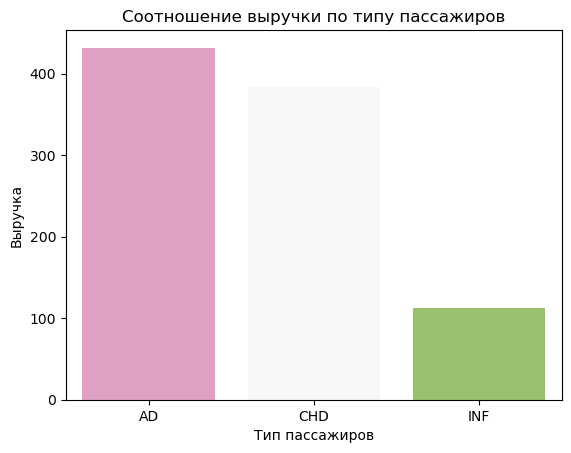

In [118]:
sns.barplot(data=good_data, x='pax_type', y='revenue_amount', palette="PiYG",errorbar=None).set(title='Соотношение выручки по типу пассажиров', xlabel='Тип пассажиров', ylabel='Выручка')
plt.show()

In [119]:
good_data['revenue_amount'].corr(good_data['pax_code'])

-0.052902251821316

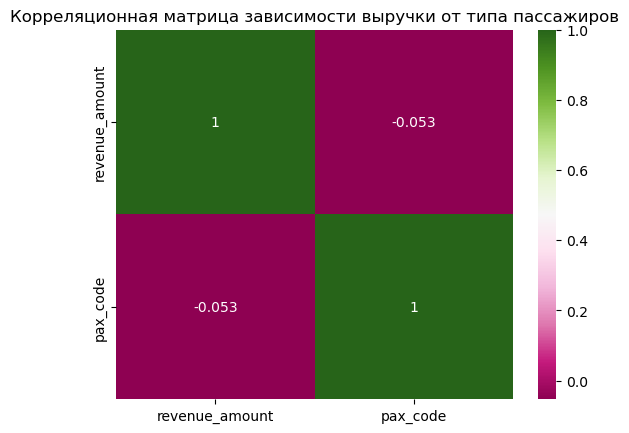

In [120]:
pax_dependence = good_data[['revenue_amount', 'pax_code']]

sns.heatmap(pax_dependence.corr(), annot=True, cmap='PiYG')
plt.title('Корреляционная матрица зависимости выручки от типа пассажиров')
plt.show()

In [121]:
dict_flight = {'ВВЛ': 1,
               'МВЛ': 0}
flight_code = good_data['route_flight_type'].map(dict_flight)

good_data.insert(loc = 15, column = 'flight_code', value = flight_code)
good_data.head(5)

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,pax_code,revenue_amount,orig_city_code,orig_city_name,dest_city_code,dest_city_name,direction,route_flight_type,flight_code,ffp_flag,sale_type
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,1,200,MOW,Moscow,KGD,Kaliningrad,Moscow-Kaliningrad,ВВЛ,1,False,ONLINE
1,2021-12-31,12,december,winter,2022-01-03,in advance,AD,1,610,UUS,Yuzhno-sakhalinsk,OVB,Novosibirsk,Yuzhno-sakhalinsk-Novosibirsk,ВВЛ,1,False,OFFLINE
2,2021-11-28,11,november,autumn,2022-01-04,strongly in advance,AD,1,390,KGD,Kaliningrad,MOW,Moscow,Kaliningrad-Moscow,ВВЛ,1,True,ONLINE
3,2021-12-08,12,december,winter,2022-01-05,strongly in advance,AD,1,190,VOZ,Voronezh,MOW,Moscow,Voronezh-Moscow,ВВЛ,1,False,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,1,190,MOW,Moscow,KRR,Krasnodar,Moscow-Krasnodar,ВВЛ,1,True,OFFLINE


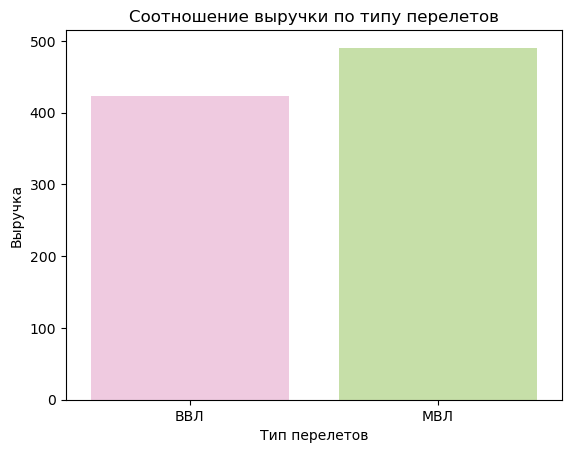

In [122]:
sns.barplot(data=good_data, x='route_flight_type', y='revenue_amount', palette="PiYG",errorbar=None).set(title='Соотношение выручки по типу перелетов', xlabel='Тип перелетов', ylabel='Выручка')
plt.show()

In [123]:
good_data['revenue_amount'].corr(good_data['flight_code'])

-0.09753521860762841

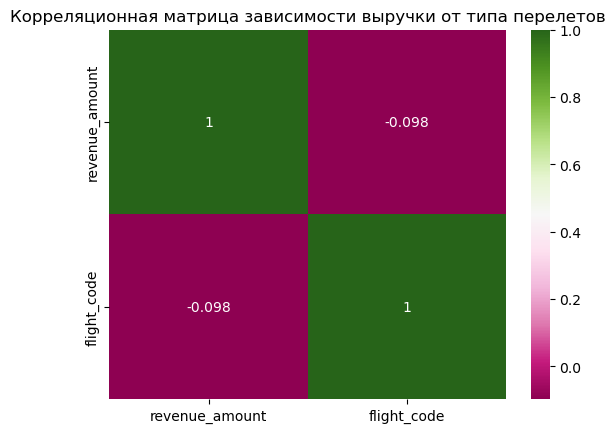

In [124]:
flight_dependence = good_data[['revenue_amount', 'flight_code']]

sns.heatmap(flight_dependence.corr(), annot=True, cmap='PiYG')
plt.title('Корреляционная матрица зависимости выручки от типа перелетов')
plt.show()

In [125]:
dict_ffp = {True: 1,
            False: 0}
ffp_code = good_data['ffp_flag'].map(dict_ffp)

good_data.insert(loc = 17, column = 'ffp_code', value = ffp_code)
good_data.head(5)

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,pax_code,revenue_amount,orig_city_code,orig_city_name,dest_city_code,dest_city_name,direction,route_flight_type,flight_code,ffp_flag,ffp_code,sale_type
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,1,200,MOW,Moscow,KGD,Kaliningrad,Moscow-Kaliningrad,ВВЛ,1,False,0,ONLINE
1,2021-12-31,12,december,winter,2022-01-03,in advance,AD,1,610,UUS,Yuzhno-sakhalinsk,OVB,Novosibirsk,Yuzhno-sakhalinsk-Novosibirsk,ВВЛ,1,False,0,OFFLINE
2,2021-11-28,11,november,autumn,2022-01-04,strongly in advance,AD,1,390,KGD,Kaliningrad,MOW,Moscow,Kaliningrad-Moscow,ВВЛ,1,True,1,ONLINE
3,2021-12-08,12,december,winter,2022-01-05,strongly in advance,AD,1,190,VOZ,Voronezh,MOW,Moscow,Voronezh-Moscow,ВВЛ,1,False,0,ONLINE
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,1,190,MOW,Moscow,KRR,Krasnodar,Moscow-Krasnodar,ВВЛ,1,True,1,OFFLINE


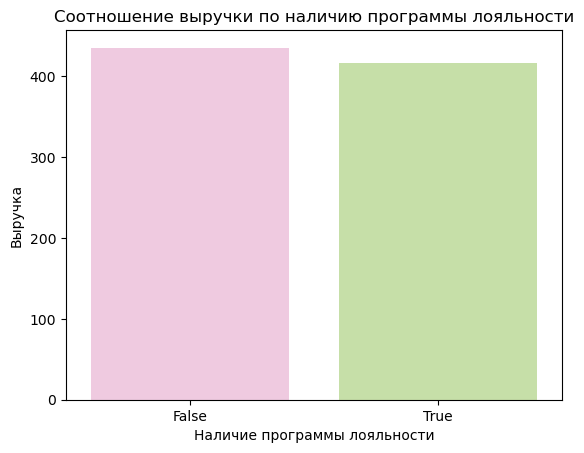

In [126]:
sns.barplot(data=good_data, x='ffp_flag', y='revenue_amount', palette="PiYG",errorbar=None).set(title='Соотношение выручки по наличию программы лояльности', xlabel='Наличие программы лояльности', ylabel='Выручка')
plt.show()

In [127]:
good_data['revenue_amount'].corr(good_data['ffp_code'])

-0.05080566224103714

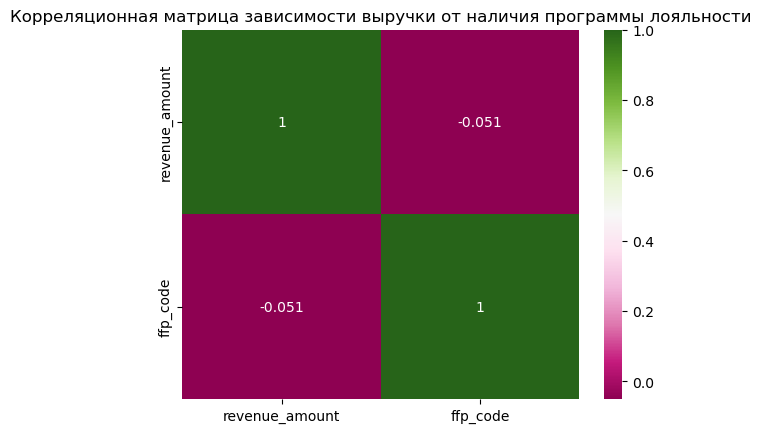

In [128]:
ffp_dependence = good_data[['revenue_amount', 'ffp_code']]

sns.heatmap(ffp_dependence.corr(), annot=True, cmap='PiYG')
plt.title('Корреляционная матрица зависимости выручки от наличия программы лояльности')
plt.show()

In [129]:
dict_sale = {'ONLINE': 1,
             'OFFLINE': 0}
sale_code = good_data['sale_type'].map(dict_sale)

good_data.insert(loc = 19, column = 'sale_code', value = sale_code)
good_data.head(5)

,issue_date,mounth,mounth_name,season_name,flight_date_loc,time_name,pax_type,pax_code,revenue_amount,orig_city_code,orig_city_name,dest_city_code,dest_city_name,direction,route_flight_type,flight_code,ffp_flag,ffp_code,sale_type,sale_code
0,2021-12-07,12,december,winter,2022-01-11,strongly in advance,AD,1,200,MOW,Moscow,KGD,Kaliningrad,Moscow-Kaliningrad,ВВЛ,1,False,0,ONLINE,1
1,2021-12-31,12,december,winter,2022-01-03,in advance,AD,1,610,UUS,Yuzhno-sakhalinsk,OVB,Novosibirsk,Yuzhno-sakhalinsk-Novosibirsk,ВВЛ,1,False,0,OFFLINE,0
2,2021-11-28,11,november,autumn,2022-01-04,strongly in advance,AD,1,390,KGD,Kaliningrad,MOW,Moscow,Kaliningrad-Moscow,ВВЛ,1,True,1,ONLINE,1
3,2021-12-08,12,december,winter,2022-01-05,strongly in advance,AD,1,190,VOZ,Voronezh,MOW,Moscow,Voronezh-Moscow,ВВЛ,1,False,0,ONLINE,1
4,2021-12-08,12,december,winter,2022-01-12,strongly in advance,AD,1,190,MOW,Moscow,KRR,Krasnodar,Moscow-Krasnodar,ВВЛ,1,True,1,OFFLINE,0


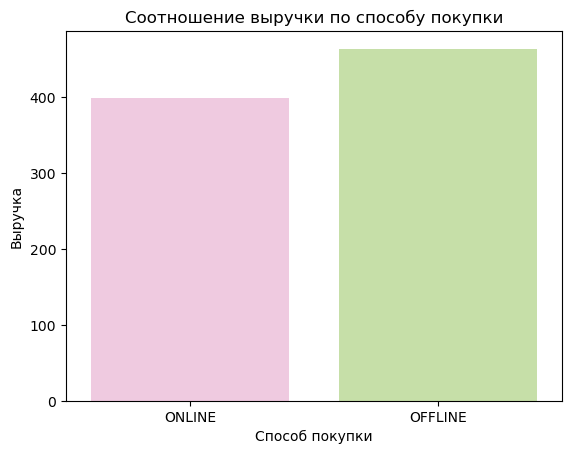

In [130]:
sns.barplot(data=good_data, x='sale_type', y='revenue_amount', palette="PiYG",errorbar=None).set(title='Соотношение выручки по способу покупки', xlabel='Способ покупки', ylabel='Выручка')
plt.show()

In [131]:
good_data['revenue_amount'].corr(good_data['sale_code'])

-0.17191104612371255

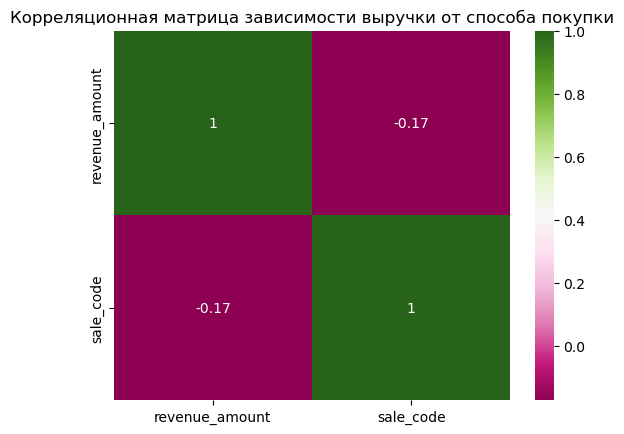

In [132]:
sale_dependence = good_data[['revenue_amount', 'sale_code']]

sns.heatmap(sale_dependence.corr(), annot=True, cmap='PiYG')
plt.title('Корреляционная матрица зависимости выручки от способа покупки')
plt.show()

Построим общую матрицу корреляций

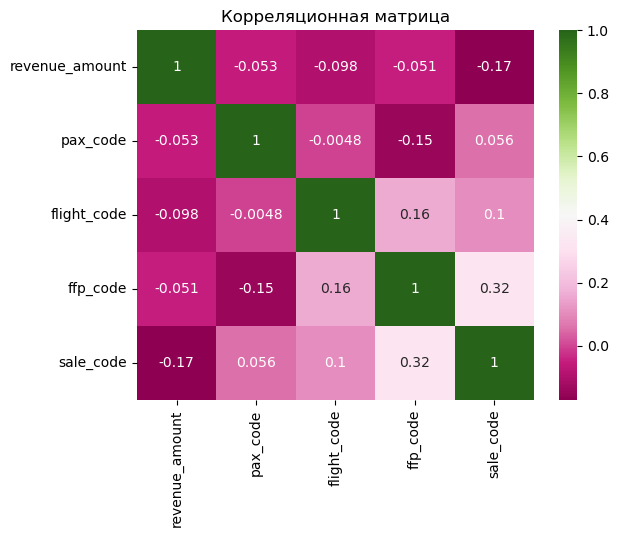

In [133]:
full_dependence = good_data[['revenue_amount', 'pax_code', 'flight_code', 'ffp_code', 'sale_code']]

sns.heatmap(full_dependence.corr(), annot=True, cmap='PiYG')
plt.title('Корреляционная матрица')
plt.show()
#по цветовой гамме получился винегрет 

<div class="alert alert-block alert-success">
<b>Вывод:</b><br>
    1. Между выручкой и изученными факторами наблюдается обратная связь. Относительно каждого фактора это трактуется по разному, в зависимости от выбранных числовых обозначений. <br>
    2. Наибольшая связь наблюдается между способом покупки и наличием программы лояльности. <br>
    3. Меньше всего связаны тип пассажира и тип полета.

[Вернуться к навигации](#15th)